<a href="https://colab.research.google.com/github/danort92/Energy-Consumption-Forecasting/blob/main/Energy_Consumption_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

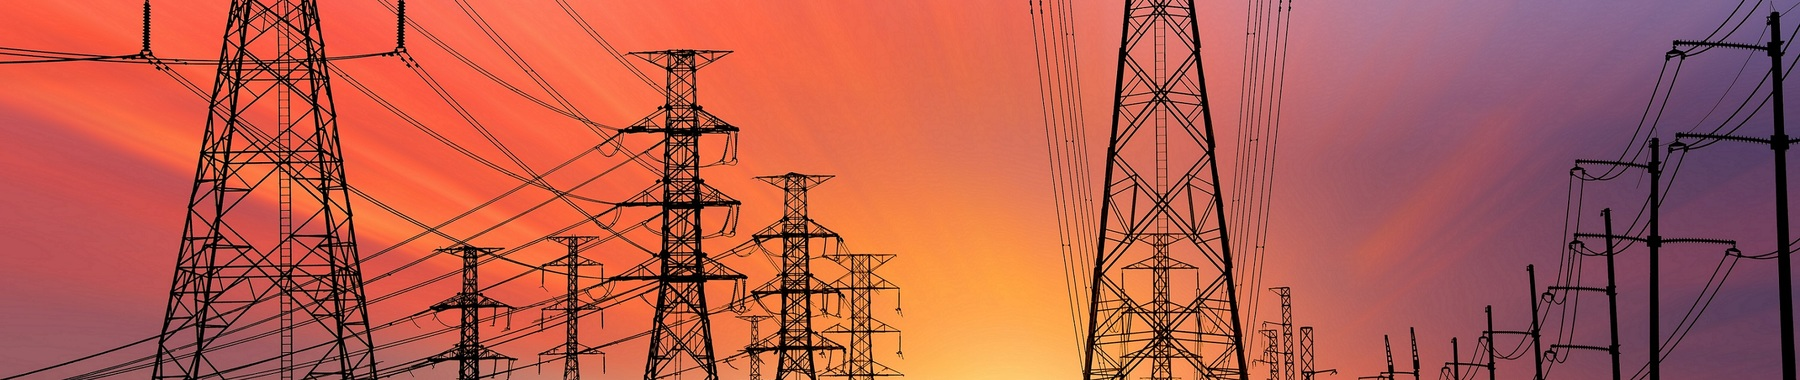

# INSTALLING

In [1]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas as pd

# IMPORT LIBRARIES

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
current_palette = sns.color_palette()
from sklearn.metrics import mean_squared_error

# FUNCTIONS

In [3]:
def prepare_time_series_df(file_path, datetime_col="Datetime", target_col=None):
    """
    Prepares a time series DataFrame from a CSV file.

    Parameters:
        file_path (str): Path to the CSV file.
        datetime_col (str): Name of the column containing datetime information. Default is "Datetime".
        target_col (str): Optional name of the target column to check for validity.

    Returns:
        pd.DataFrame: Cleaned and sorted DataFrame with datetime index.
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Parse datetime column
    if datetime_col not in df.columns:
        raise ValueError(f"Column '{datetime_col}' not found in the dataset.")

    df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")

    # Drop rows where datetime conversion failed
    df = df.dropna(subset=[datetime_col])

    # Set the datetime column as the index
    df = df.set_index(datetime_col)

    # Sort the DataFrame by datetime index
    df = df.sort_index()

    # Optional: Check if the target column exists
    if target_col and target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the dataset.")

    return df


In [4]:
def create_lagged_features(df, target_col, freq):
    """
    Creates lagged features for a time series dataset, ensuring consistent lag names across all frequencies.
    This version explicitly maps lags using the datetime index to handle potential gaps.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a datetime index.
        target_col (str): Name of the target variable (e.g., energy consumption).
        freq (str): Frequency for lag creation ('H', 'D', 'W', 'M', 'A').

    Returns:
        pd.DataFrame: DataFrame with lagged features.
    """
    # Define the lag durations in a timedelta format
    lag_map = {
        "1H": pd.Timedelta(hours=1),
        "1D": pd.Timedelta(days=1),
        "1W": pd.Timedelta(weeks=1),
        "1M": pd.Timedelta(days=30),  # Approx. 1 month
        "1Y": pd.Timedelta(days=365),  # Approx. 1 year
        "3Y": pd.Timedelta(days=365 * 3)  # Approx. 3 years
    }

    # Map the requested frequency to the corresponding lag durations
    freq_map = {
        "H": ["1H", "1D", "1W", "1M", "1Y", "3Y"],  # Hourly frequency
        "D": ["1D", "1W", "1M", "1Y", "3Y"],  # Daily frequency
        "W": ["1W", "1M", "1Y", "3Y"],  # Weekly frequency
        "M": ["1M", "1Y", "3Y"],  # Monthly frequency
        "A": ["1Y", "3Y"]   # Yearly frequency
    }

    if freq not in freq_map:
        raise ValueError("Invalid frequency. Choose from 'H', 'D', 'W', 'M', 'A'.")

    # Create lagged features based on the datetime index
    for lag_str in freq_map[freq]:
        lag_duration = lag_map[lag_str]
        lag_name = f"Lag{lag_str}"  # Name the lag feature consistently

        # Calculate lagged values by shifting based on datetime index
        df[lag_name] = df[target_col].reindex(
            df.index - lag_duration
        ).values

    return df


In [5]:
def create_time_series_features(df, target_col):
    """
    Creates time-based features for a time series dataset with a datetime index.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a datetime index.
        target_col (str): Name of the target variable (e.g., energy consumption).

    Returns:
        pd.DataFrame: DataFrame with additional time-based features.
    """
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Ensure the index is a datetime object
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")

    # Extract time-based features from the index
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['IsWeekend'] = (df.index.dayofweek >= 5).astype(int)

    # Add season feature
    def get_season(month):
        if month in [12, 1, 2]:
            return 1  # Winter
        elif month in [3, 4, 5]:
            return 2  # Spring
        elif month in [6, 7, 8]:
            return 3  # Summer
        else:
            return 4  # Autumn
    df['Season'] = df['Month'].apply(get_season)

    return df


In [6]:
def check_and_drop_duplicates(df, keep="first"):
    """
    Checks for and drops duplicate indices in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a datetime index.
        keep (str): Which duplicate to keep - 'first', 'last', or False to drop all. Default is 'first'.

    Returns:
        pd.DataFrame: DataFrame with duplicate indices removed.
    """
    # Check for duplicate indices
    duplicates = df.index[df.index.duplicated(keep=False)]

    if not duplicates.empty:
        print(f"Found {len(duplicates)} duplicate index entries.")
        print(f"Duplicate indices: {duplicates.unique()}")

        # Drop duplicate indices
        df = df[~df.index.duplicated(keep=keep)]
        print("Duplicates dropped.")
    else:
        print("No duplicate indices found.")

    return df


In [24]:
def train_xgb_model(X_train, y_train, X_test, y_test,
                    n_estimators=2000, learning_rate=0.05, max_depth=6,
                    random_state=42, early_stopping_rounds=50, verbose=100):
    """
    Trains an XGBoost regressor with specified parameters.

    Parameters:
        X_train (pd.DataFrame or np.ndarray): Training feature set.
        y_train (pd.Series or np.ndarray): Training target variable.
        X_test (pd.DataFrame or np.ndarray): Testing feature set for evaluation.
        y_test (pd.Series or np.ndarray): Testing target variable for evaluation.
        n_estimators (int): Number of boosting rounds (trees).
        learning_rate (float): Step size shrinkage to prevent overfitting.
        max_depth (int): Maximum depth of each tree.
        random_state (int): Seed for reproducibility.
        early_stopping_rounds (int): Stop training if no improvement after these rounds.
        verbose (int): Frequency of logging progress during training.

    Returns:
        xgb_model: Trained XGBoost model.
    """
    # Initialize the model
    xgb_model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state,
        early_stopping_rounds=early_stopping_rounds
    )

    # Fit the model
    xgb_model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],  # Evaluation set to monitor performance
        verbose=verbose               # Log progress every `verbose` iterations
    )

    return xgb_model


In [8]:
def plot_14_day_interval(y_test, y_pred, start_date):
    """
    Plots a 14-day interval of actual and predicted energy consumption.

    Parameters:
        y_test (pd.Series): Actual values with datetime index.
        y_pred (array-like or pd.Series): Predicted values.
        start_date (str): Start date of the interval (format: 'YYYY-MM-DD').
    """
    # Ensure y_pred is a pandas Series with the same index as y_test
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=y_test.index)

    # Convert start_date to pandas Timestamp
    start_date = pd.Timestamp(start_date)
    end_date = start_date + pd.Timedelta(days=14)

    # Filter data for the 14-day interval
    actual_data = y_test.loc[(y_test.index >= start_date) & (y_test.index < end_date)]
    predicted_data = y_pred.loc[(y_pred.index >= start_date) & (y_pred.index < end_date)]

    # Plot actual data as a line
    plt.figure(figsize=(15, 5))
    plt.plot(
        actual_data.index,
        actual_data,
        label=f"Actual (Interval: {start_date.date()} to {end_date.date()})",
        color="red",
        alpha=0.8,
    )

    # Plot predicted data as dots
    plt.scatter(
        predicted_data.index,
        predicted_data,
        label="Predicted",
        color="green",
        alpha=0.8,
        s=15,
    )

    # Add labels, legend, and title
    plt.title(f"Energy Consumption: 14-Day Interval Starting {start_date.date()}")
    plt.xlabel("Datetime")
    plt.ylabel("Energy Consumption (MW)")
    plt.legend()
    plt.show()


# DATASET

## DOWNLOAD DATASET

In [9]:
od.download("https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: daniloortelli
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption


100%|██████████| 11.4M/11.4M [00:00<00:00, 123MB/s]

In [10]:
file_path = "/content/hourly-energy-consumption/PJME_hourly.csv"
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")

## DROP DUPLICATES & CREATE ADDITIONAL FEATURES

In [11]:
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


# EDA

In [12]:
df.head()

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
Datetime                                                                   
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   

                     IsWeekend  Season  
Datetime                                
2002-01-01 01:00:00          0       1  
2002-01-01 02:00:00          0       1  
2002-01-01 03:00:00          0       1  
2002-01-01 04:00:00          0       1  
2002-01-01 05:00:00          0       1

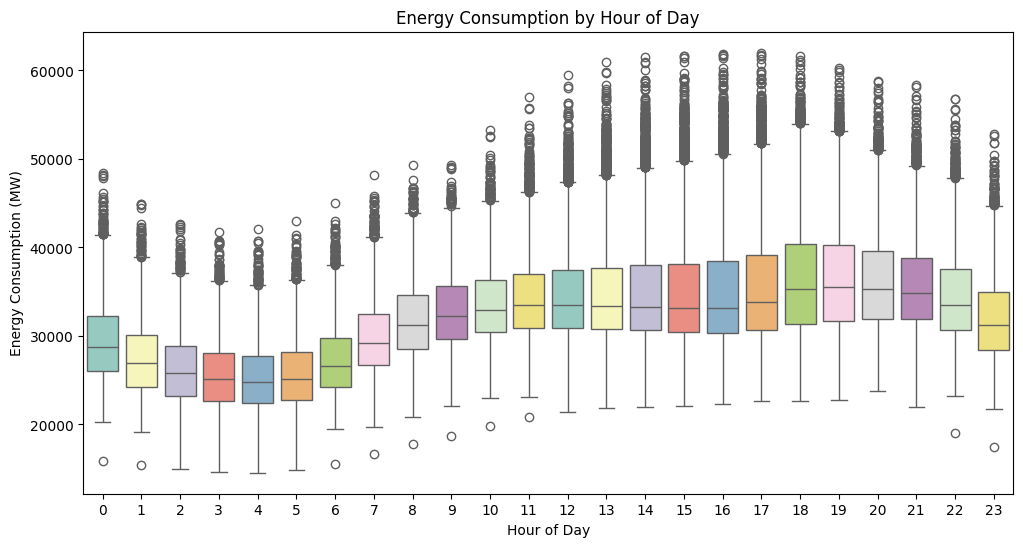

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Hour", y="PJME_MW", data=df.reset_index(), palette="Set3", hue="Hour", legend=False)
plt.title("Energy Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Energy Consumption (MW)")
plt.show()

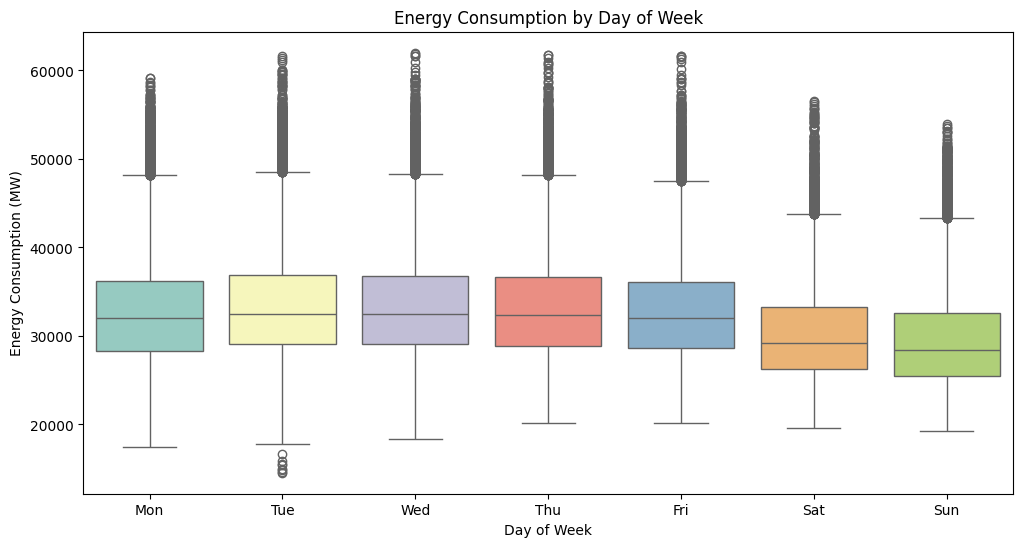

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="DayOfWeek", y="PJME_MW", data=df.reset_index(), palette="Set3", hue="DayOfWeek", legend=False)
plt.title("Energy Consumption by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Energy Consumption (MW)")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()

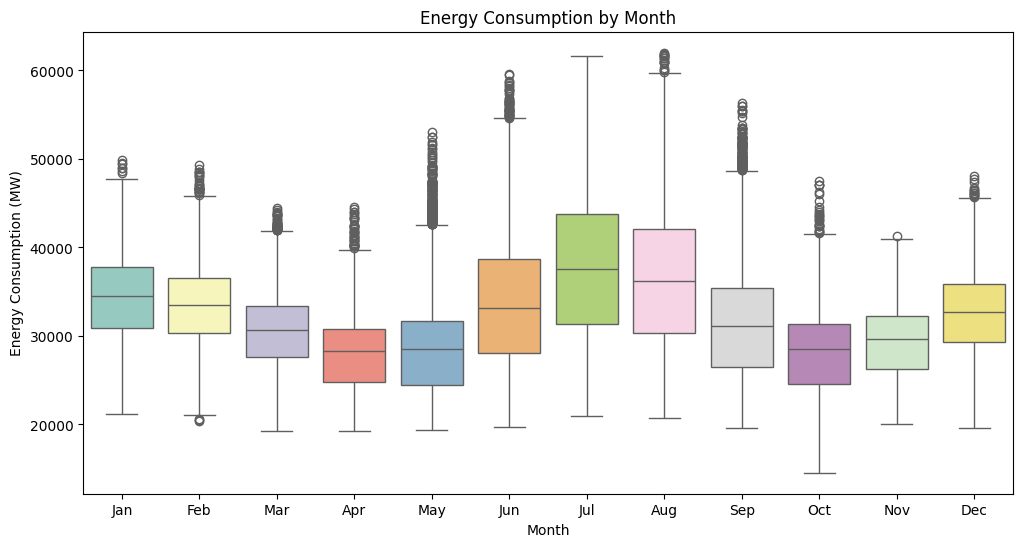

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Month", y="PJME_MW", data=df.reset_index(), palette="Set3", hue="Month", legend=False)
plt.title("Energy Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Energy Consumption (MW)")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                       "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

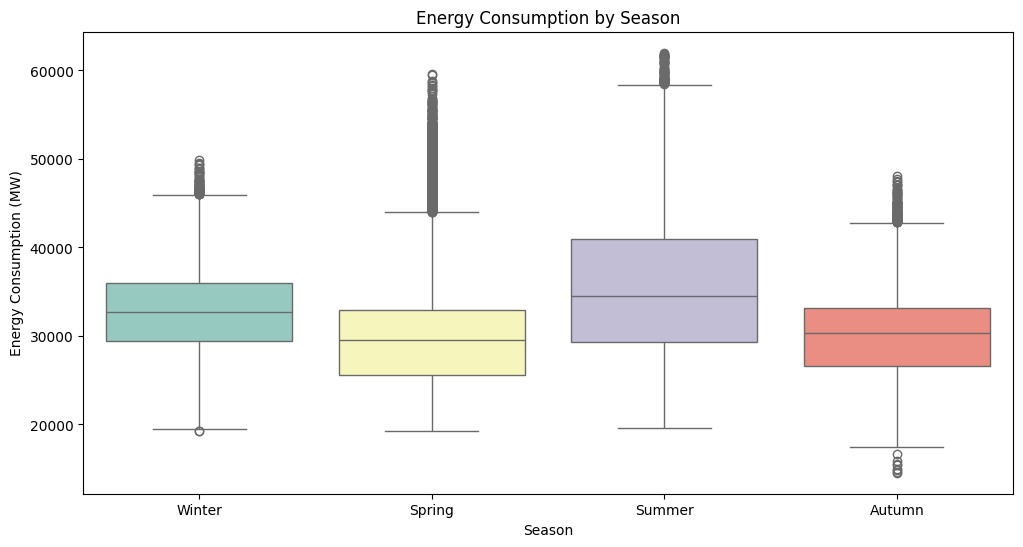

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Quarter", y="PJME_MW", data=df.reset_index(), palette="Set3", hue="Quarter", legend=False)
plt.title("Energy Consumption by Season")
plt.xlabel("Season")
plt.ylabel("Energy Consumption (MW)")
plt.xticks(ticks=range(4), labels=["Winter", "Spring", "Summer", "Autumn"])
plt.show()

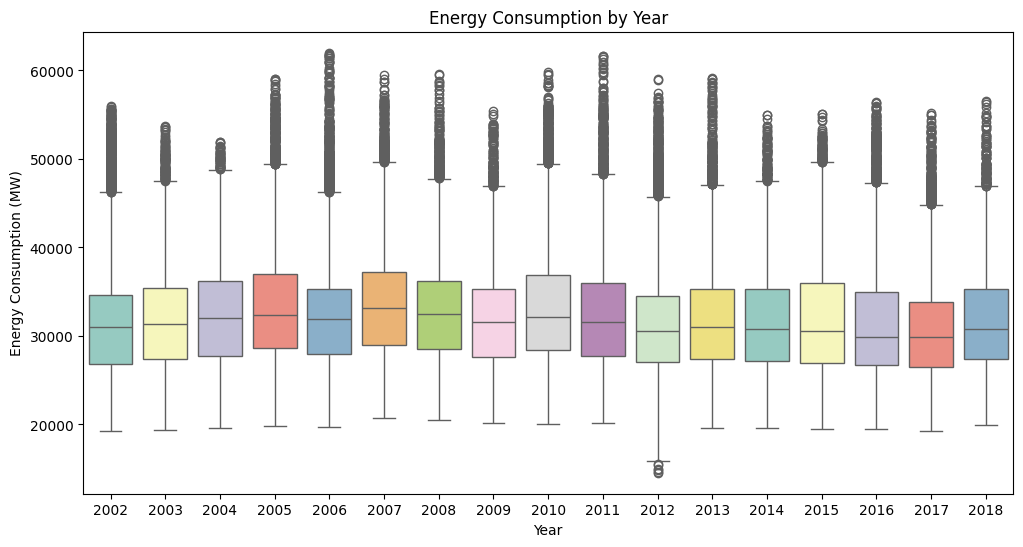

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Year", y="PJME_MW", data=df.reset_index(), palette="Set3", hue="Year", legend=False)
plt.title("Energy Consumption by Year")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (MW)")
plt.show()

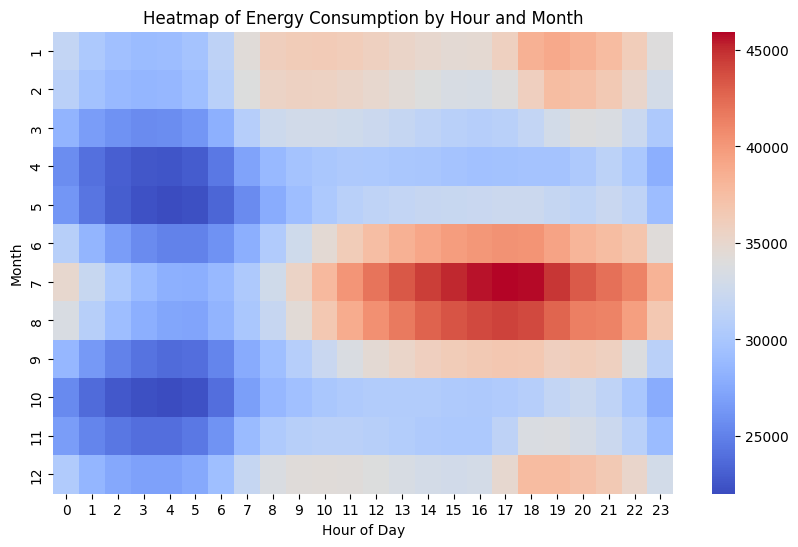

In [18]:
# Group by hour and month
hourly_avg = df.groupby("Hour")["PJME_MW"].mean()
monthly_avg = df.groupby("Month")["PJME_MW"].mean()

# Heatmap for hours and months
hour_month_avg = df.groupby([df.index.month, df.index.hour])["PJME_MW"].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(hour_month_avg, cmap="coolwarm", annot=False, fmt=".1f")
plt.title("Heatmap of Energy Consumption by Hour and Month")
plt.xlabel("Hour of Day")
plt.ylabel("Month")
plt.show()

<Axes: title={'center': 'Energy consumption in MW'}, xlabel='Datetime'>

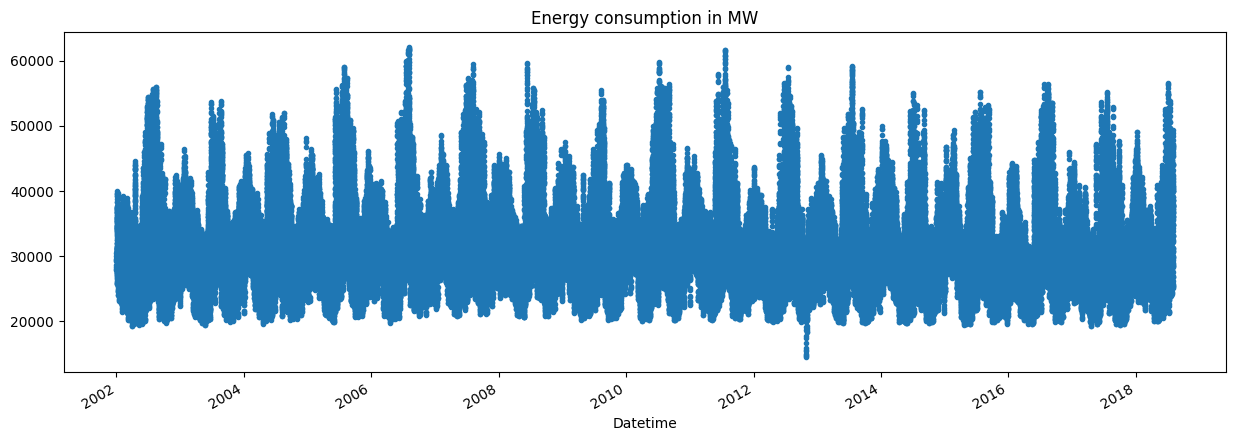

In [19]:
df["PJME_MW"].plot(style = ".", figsize = (15,5), color = current_palette[0], title = "Energy consumption in MW")

<Axes: title={'center': 'Energy consumption in MW'}, xlabel='Datetime'>

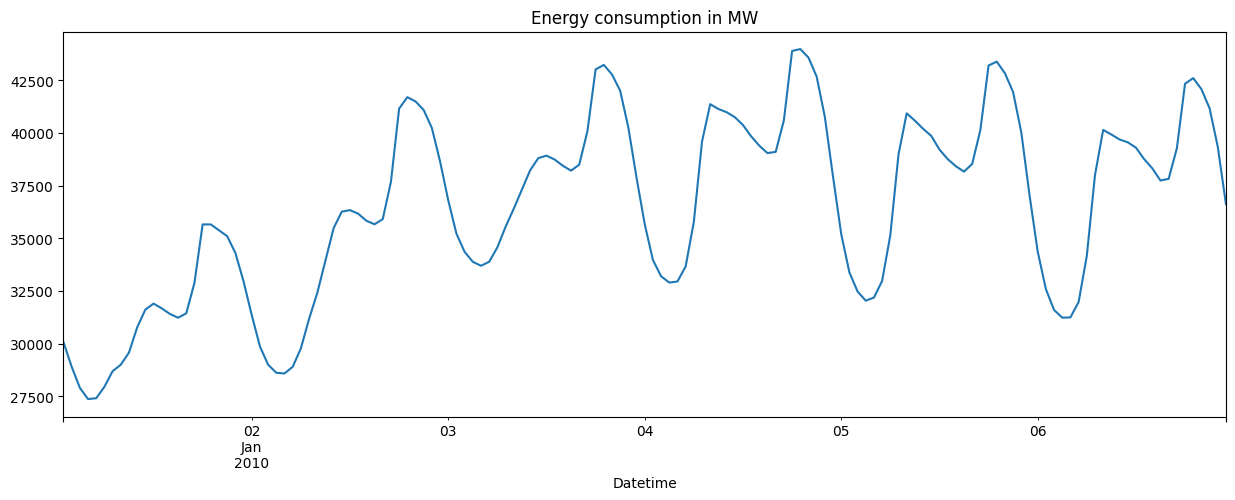

In [20]:
weekly_data=df["PJME_MW"].loc[(df.index > "01-01-2010") & (df.index < "01-07-2010")]
weekly_data.plot(figsize = (15,5), color = current_palette[0], title = "Energy consumption in MW")

# ENERGY CONSUMPTION PREDICTION & COMPARISON WITH ACTUAL VALUES

## CASE 1

### TRAIN-TEST SPLIT

In [26]:
train = df.loc[(df.index < "01-01-2015")]
test = df.loc[(df.index >= "01-01-2015")]

X_train = train.drop(columns=["PJME_MW"])
y_train = train["PJME_MW"]
X_test = test.drop(columns=["PJME_MW"])
y_test = test["PJME_MW"]

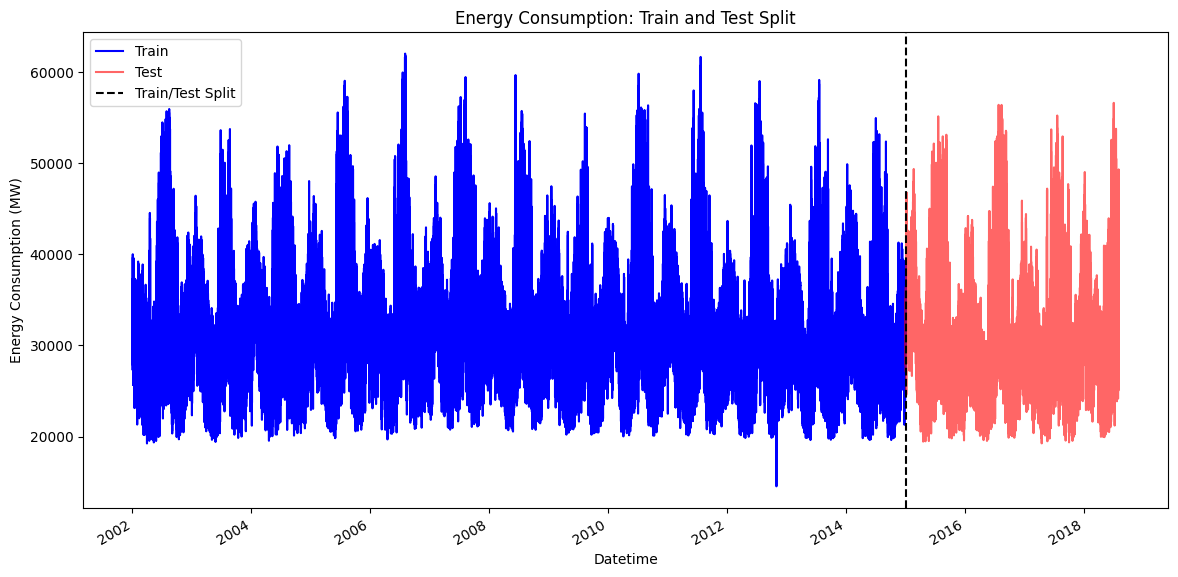

In [27]:
split_date = "2015-01-01"

# Plot the train data in blue
train["PJME_MW"].plot(figsize=(14, 7), color="blue", label="Train")

# Plot the test data in red
test["PJME_MW"].plot(color="red", alpha=0.6, label="Test")

# Add a vertical line for the split date
plt.axvline(x=split_date, color="black", linestyle="--", label="Train/Test Split")

# Add labels and title
plt.title("Energy Consumption: Train and Test Split")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")
plt.legend()

# Show the plot
plt.show()

### MODEL

#### RUN MODEL

In [28]:
xgb_model = train_xgb_model(X_train, y_train, X_test, y_test)

[0]	validation_0-rmse:6316.92829
[100]	validation_0-rmse:3803.25674
[130]	validation_0-rmse:3857.40992


#### PREDICTION & EVALUATION

In [29]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 3784.14947984031


#### SAVE ERROR

In [30]:
rms_error=[]
rms_error.append(rmse)

### PLOT RESULTS ON 14 TIME INTERVAL

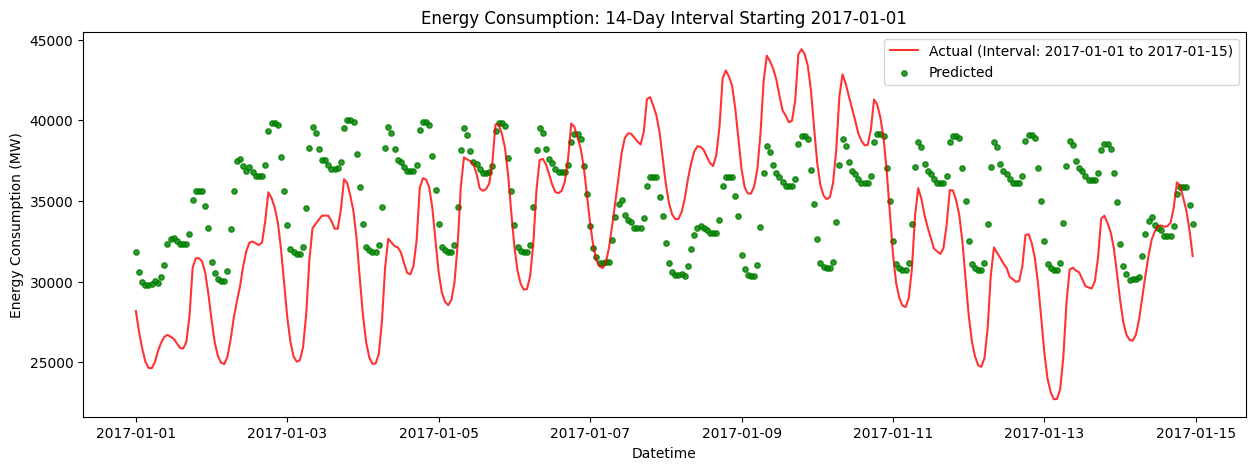

In [31]:
start_date = "2017-01-01"
plot_14_day_interval(y_test, y_pred, start_date)

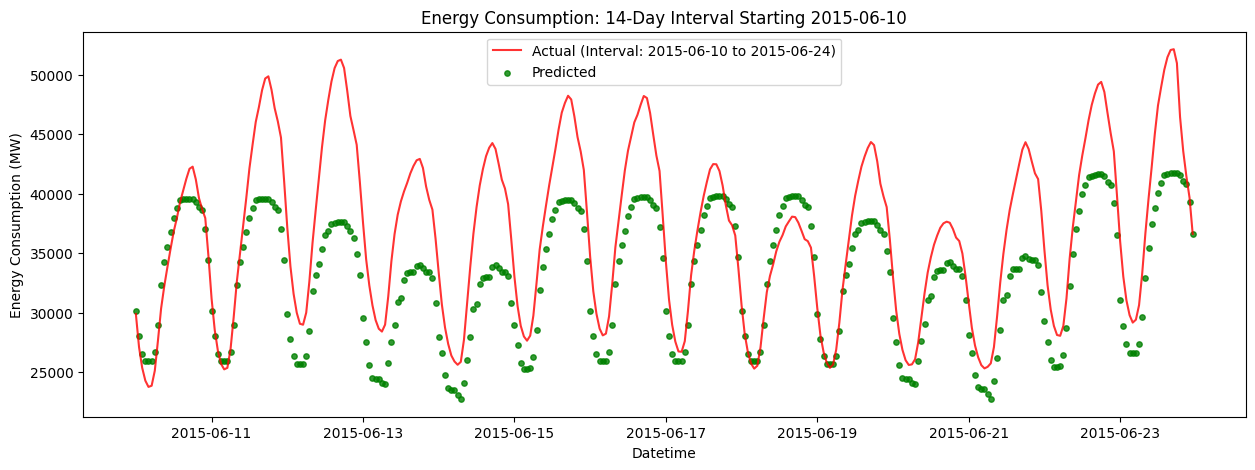

In [32]:
start_date = "2015-06-10"
plot_14_day_interval(y_test, y_pred, start_date)

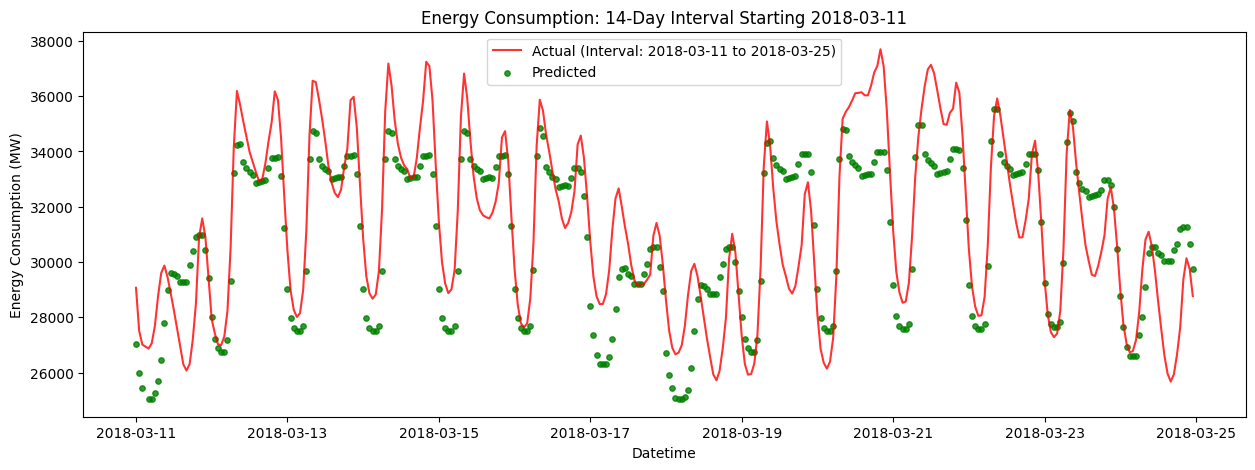

In [33]:
start_date = "2018-03-11"
plot_14_day_interval(y_test, y_pred, start_date)

## CASE 2: ADD LAG FEATURES - YEARLY FREQUENCY

### CREATE LAG FEATURES

In [34]:
df = create_lagged_features(df, target_col="PJME_MW", freq="A")
df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
Datetime                                                                   
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-08-02 20:00:00  44057.0  2018        3      8    2    20          3   
2018-08-02 21:00:00  43256.0  2018        3      8    2    21          3   
2018-08-02 22:00:00  41552.0  2018        3      8    2    22          3   
2018-08-02 23:00:00  38500.0  2018        3      8    2    23          3   
2018-08-03 00:00:00  35486.0  2018        3      8    3     0          4   

                     IsWeekend  Season    Lag1Y    Lag3Y  
Datetime                                                  
2002-01-01 01:00:00          0       1      NaN      NaN  
2002-01-01 02:00:00          0       1      NaN      NaN  
2002-01-01 03:00:00          0       1      NaN      NaN  
2002-01-01 04:00:00          0       1      NaN      NaN  
2002-01-01 05:00:00          0       1      NaN      NaN  
...                        ...     ...      ...      ...  
2018-08-02 20:00:00          0       3  39352.0  46942.0  
2018-08-02 21:00:00          0       3  38699.0  45730.0  
2018-08-02 22:00:00          0       3  37346.0  43954.0  
2018-08-02 23:00:00          0       3  34555.0  40390.0  
2018-08-03 00:00:00          0       3  31646.0  36825.0  

[145362 rows x 11 columns]

### TRAIN-TEST SPLIT

In [35]:
train = df.loc[(df.index < "01-01-2015")]
test = df.loc[(df.index >= "01-01-2015")]

X_train = train.drop(columns=["PJME_MW"])
y_train = train["PJME_MW"]
X_test = test.drop(columns=["PJME_MW"])
y_test = test["PJME_MW"]

### MODEL

#### RUN MODEL

In [36]:
xgb_model = train_xgb_model(X_train, y_train, X_test, y_test)

[0]	validation_0-rmse:6320.93178
[100]	validation_0-rmse:3891.97887
[118]	validation_0-rmse:3921.71306


#### PREDICTION & EVALUATION

In [37]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 3869.049666210948


#### SAVE ERROR

In [38]:
rms_error.append(rmse)

### PLOT RESULTS ON 14 TIME INTERVAL

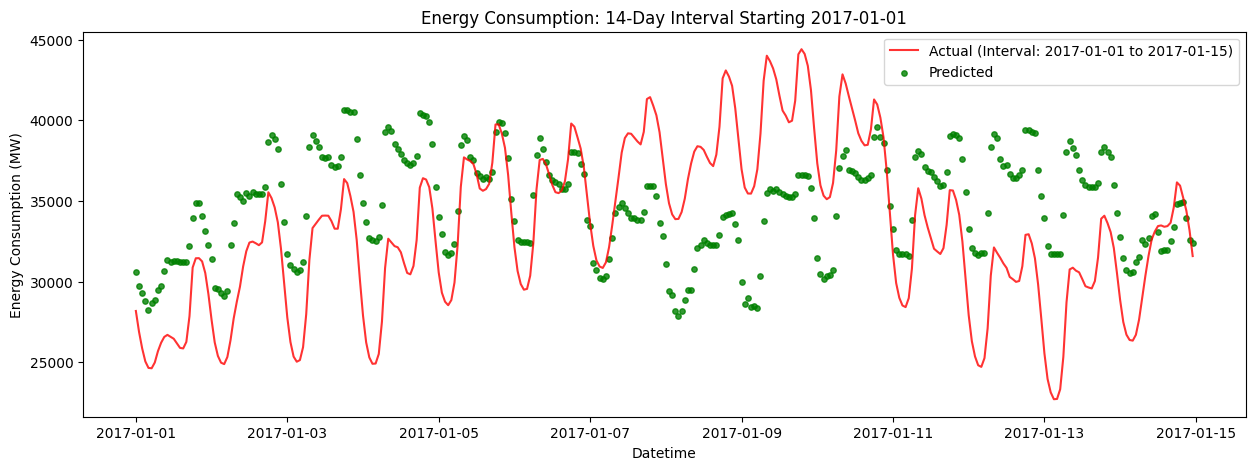

In [39]:
start_date = "2017-01-01"
plot_14_day_interval(y_test, y_pred, start_date)

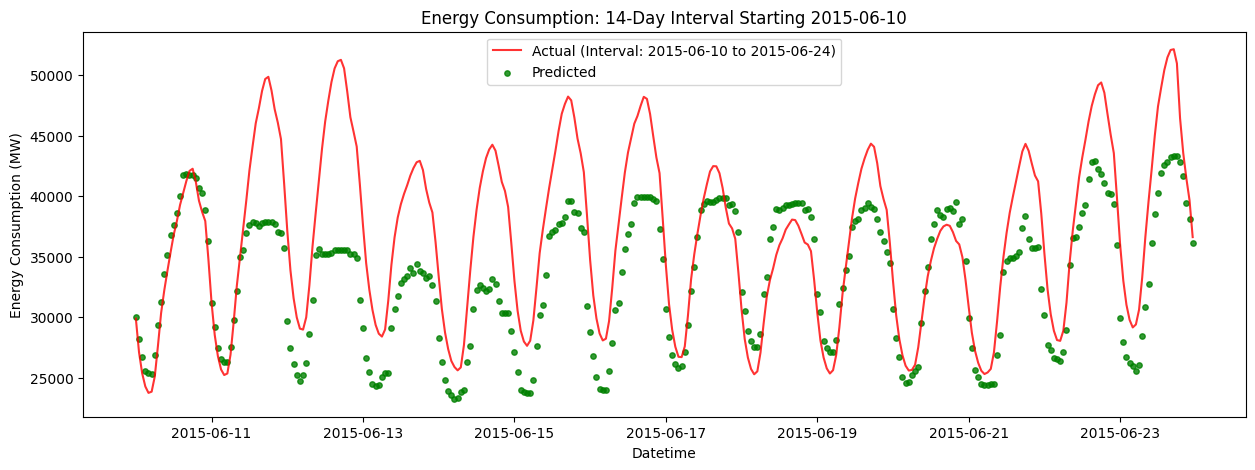

In [40]:
start_date = "2015-06-10"
plot_14_day_interval(y_test, y_pred, start_date)

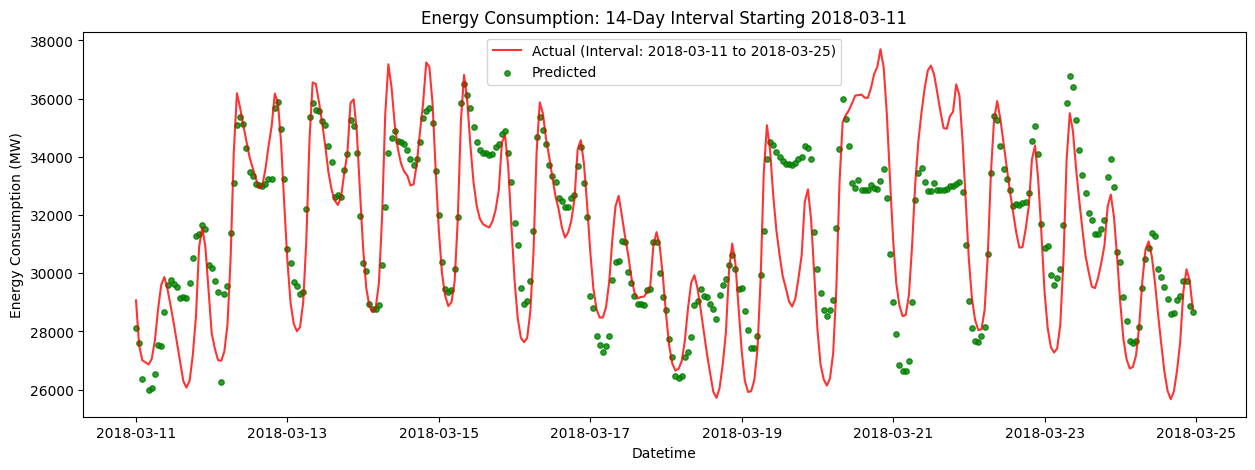

In [41]:
start_date = "2018-03-11"
plot_14_day_interval(y_test, y_pred, start_date)

## CASE 3: ADD LAG FEATURES - MONTHLY FREQUENCY

### CREATE LAG FEATURES

In [42]:
file_path = "/content/hourly-energy-consumption/PJME_hourly.csv"
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


In [43]:
df = create_lagged_features(df, target_col="PJME_MW", freq="M")
df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
Datetime                                                                   
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-08-02 20:00:00  44057.0  2018        3      8    2    20          3   
2018-08-02 21:00:00  43256.0  2018        3      8    2    21          3   
2018-08-02 22:00:00  41552.0  2018        3      8    2    22          3   
2018-08-02 23:00:00  38500.0  2018        3      8    2    23          3   
2018-08-03 00:00:00  35486.0  2018        3      8    3     0          4   

                     IsWeekend  Season    Lag1M    Lag1Y    Lag3Y  
Datetime                                                           
2002-01-01 01:00:00          0       1      NaN      NaN      NaN  
2002-01-01 02:00:00          0       1      NaN      NaN      NaN  
2002-01-01 03:00:00          0       1      NaN      NaN      NaN  
2002-01-01 04:00:00          0       1      NaN      NaN      NaN  
2002-01-01 05:00:00          0       1      NaN      NaN      NaN  
...                        ...     ...      ...      ...      ...  
2018-08-02 20:00:00          0       3  49244.0  39352.0  46942.0  
2018-08-02 21:00:00          0       3  47292.0  38699.0  45730.0  
2018-08-02 22:00:00          0       3  45506.0  37346.0  43954.0  
2018-08-02 23:00:00          0       3  42437.0  34555.0  40390.0  
2018-08-03 00:00:00          0       3  39340.0  31646.0  36825.0  

[145362 rows x 12 columns]

### TRAIN-TEST SPLIT

In [44]:
train = df.loc[(df.index < "01-01-2015")]
test = df.loc[(df.index >= "01-01-2015")]

X_train = train.drop(columns=["PJME_MW"])
y_train = train["PJME_MW"]
X_test = test.drop(columns=["PJME_MW"])
y_test = test["PJME_MW"]

### MODEL

#### RUN MODEL

In [45]:
xgb_model = train_xgb_model(X_train, y_train, X_test, y_test)

[0]	validation_0-rmse:6321.65299
[100]	validation_0-rmse:3903.13689
[119]	validation_0-rmse:3927.45821


#### PREDICTION & EVALUATION

In [46]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 3861.993507935445


#### SAVE ERROR

In [47]:
rms_error.append(rmse)

### PLOT RESULTS ON 14 TIME INTERVAL

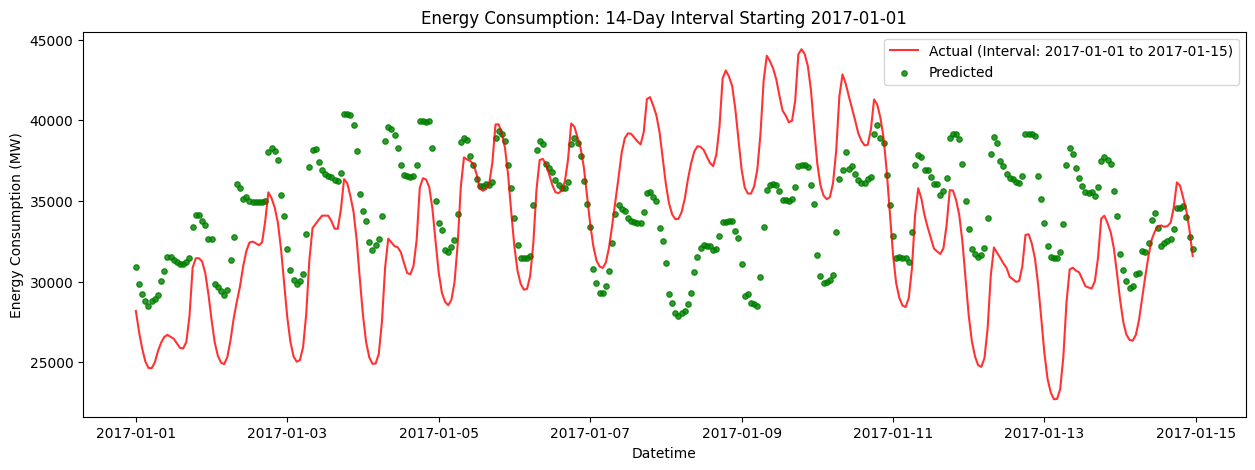

In [48]:
start_date = "2017-01-01"
plot_14_day_interval(y_test, y_pred, start_date)

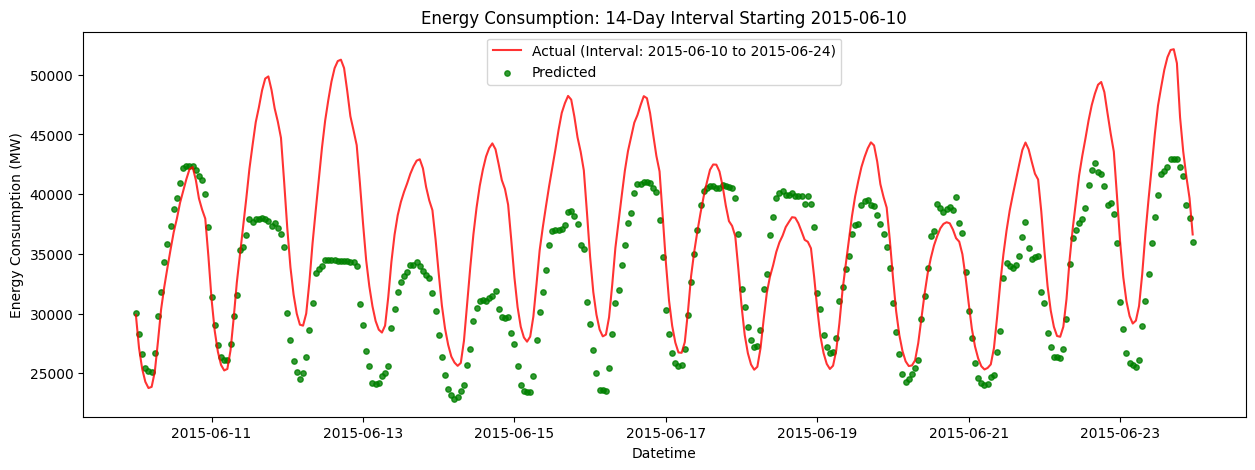

In [49]:
start_date = "2015-06-10"
plot_14_day_interval(y_test, y_pred, start_date)

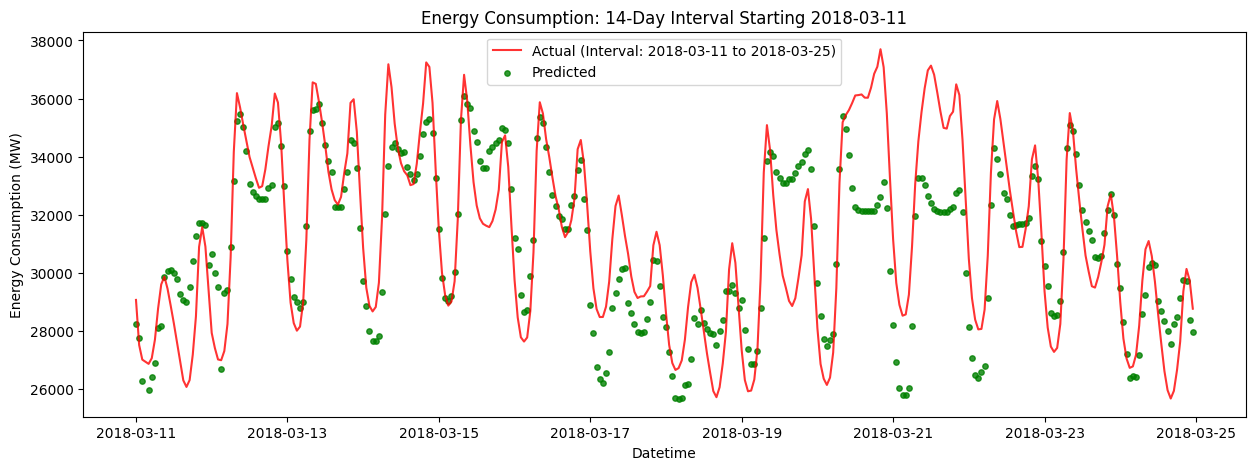

In [50]:
start_date = "2018-03-11"
plot_14_day_interval(y_test, y_pred, start_date)

## CASE 4: ADD LAG FEATURES - WEEKLY FREQUENCY

### CREATE LAG FEATURES

In [51]:
file_path = "/content/hourly-energy-consumption/PJME_hourly.csv"
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


In [52]:
df = create_lagged_features(df, target_col="PJME_MW", freq="W")
df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
Datetime                                                                   
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-08-02 20:00:00  44057.0  2018        3      8    2    20          3   
2018-08-02 21:00:00  43256.0  2018        3      8    2    21          3   
2018-08-02 22:00:00  41552.0  2018        3      8    2    22          3   
2018-08-02 23:00:00  38500.0  2018        3      8    2    23          3   
2018-08-03 00:00:00  35486.0  2018        3      8    3     0          4   

                     IsWeekend  Season    Lag1W    Lag1M    Lag1Y    Lag3Y  
Datetime                                                                    
2002-01-01 01:00:00          0       1      NaN      NaN      NaN      NaN  
2002-01-01 02:00:00          0       1      NaN      NaN      NaN      NaN  
2002-01-01 03:00:00          0       1      NaN      NaN      NaN      NaN  
2002-01-01 04:00:00          0       1      NaN      NaN      NaN      NaN  
2002-01-01 05:00:00          0       1      NaN      NaN      NaN      NaN  
...                        ...     ...      ...      ...      ...      ...  
2018-08-02 20:00:00          0       3  46337.0  49244.0  39352.0  46942.0  
2018-08-02 21:00:00          0       3  44542.0  47292.0  38699.0  45730.0  
2018-08-02 22:00:00          0       3  42638.0  45506.0  37346.0  43954.0  
2018-08-02 23:00:00          0       3  39276.0  42437.0  34555.0  40390.0  
2018-08-03 00:00:00          0       3  35742.0  39340.0  31646.0  36825.0  

[145362 rows x 13 columns]

### TRAIN-TEST SPLIT

In [53]:
train = df.loc[(df.index < "01-01-2015")]
test = df.loc[(df.index >= "01-01-2015")]

X_train = train.drop(columns=["PJME_MW"])
y_train = train["PJME_MW"]
X_test = test.drop(columns=["PJME_MW"])
y_test = test["PJME_MW"]

#### MODEL

**testo in grassetto**### RUN MODEL

In [54]:
xgb_model = train_xgb_model(X_train, y_train, X_test, y_test)

[0]	validation_0-rmse:6310.44101
[100]	validation_0-rmse:3742.52102
[120]	validation_0-rmse:3765.10695


#### PREDICTION & EVALUATION

In [55]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 3717.2753951112772


#### SAVE ERROR

In [56]:
rms_error.append(rmse)

### PLOT RESULTS ON 14 TIME INTERVAL

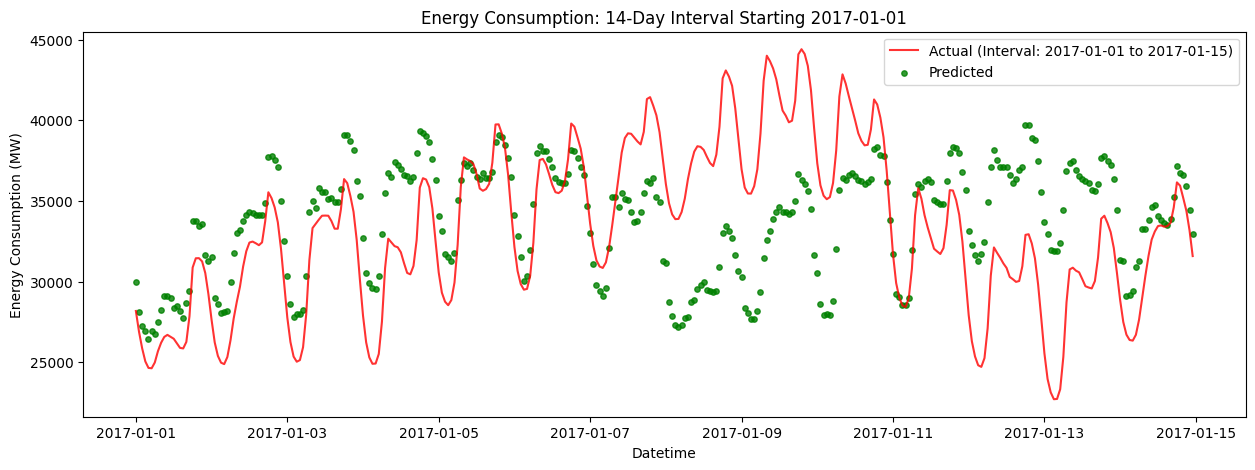

In [57]:
start_date = "2017-01-01"
plot_14_day_interval(y_test, y_pred, start_date)

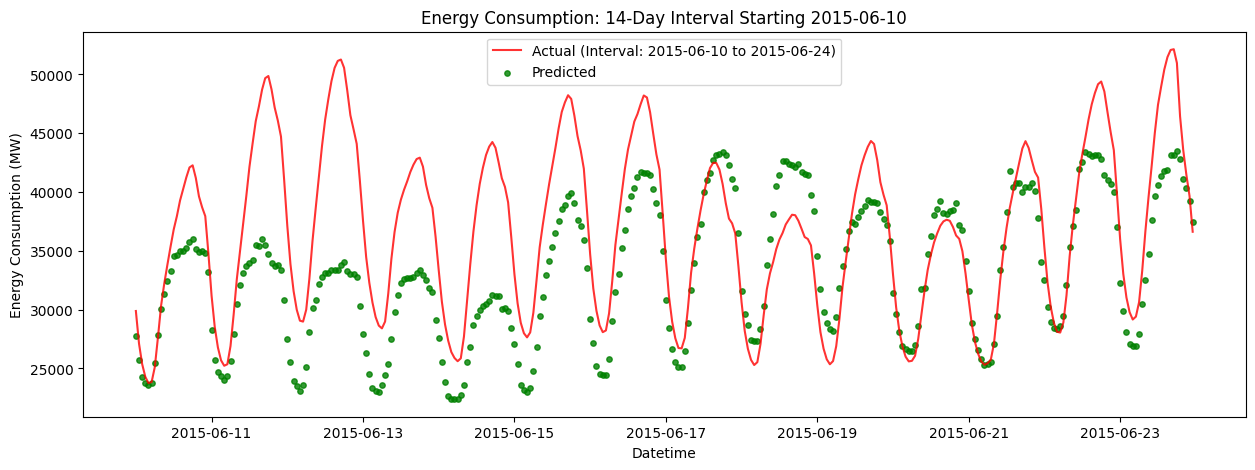

In [58]:
start_date = "2015-06-10"
plot_14_day_interval(y_test, y_pred, start_date)

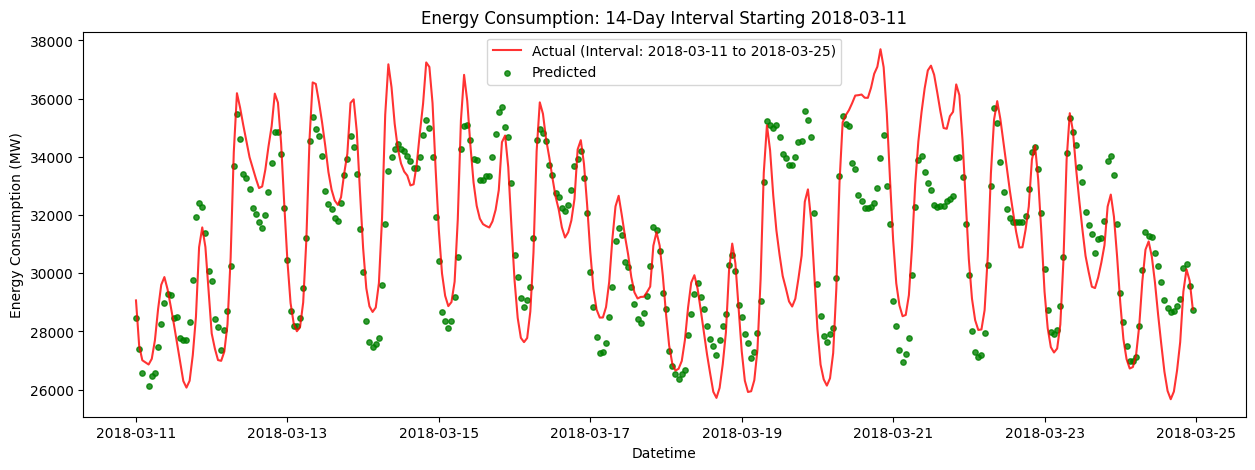

In [59]:
start_date = "2018-03-11"
plot_14_day_interval(y_test, y_pred, start_date)

## CASE 5: ADD LAG FEATURES - DAILY FREQUENCY

### CREATE LAG FEATURES

In [60]:
file_path = "/content/hourly-energy-consumption/PJME_hourly.csv"
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


In [61]:
df = create_lagged_features(df, target_col="PJME_MW", freq="D")
df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
Datetime                                                                   
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-08-02 20:00:00  44057.0  2018        3      8    2    20          3   
2018-08-02 21:00:00  43256.0  2018        3      8    2    21          3   
2018-08-02 22:00:00  41552.0  2018        3      8    2    22          3   
2018-08-02 23:00:00  38500.0  2018        3      8    2    23          3   
2018-08-03 00:00:00  35486.0  2018        3      8    3     0          4   

                     IsWeekend  Season    Lag1D    Lag1W    Lag1M    Lag1Y  \
Datetime                                                                     
2002-01-01 01:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 02:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 03:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 04:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 05:00:00          0       1      NaN      NaN      NaN      NaN   
...                        ...     ...      ...      ...      ...      ...   
2018-08-02 20:00:00          0       3  46912.0  46337.0  49244.0  39352.0   
2018-08-02 21:00:00          0       3  45985.0  44542.0  47292.0  38699.0   
2018-08-02 22:00:00          0       3  44094.0  42638.0  45506.0  37346.0   
2018-08-02 23:00:00          0       3  40666.0  39276.0  42437.0  34555.0   
2018-08-03 00:00:00          0       3  37158.0  35742.0  39340.0  31646.0   

                       Lag3Y  
Datetime                      
2002-01-01 01:00:00      NaN  
2002-01-01 02:00:00      NaN  
2002-01-01 03:00:00      NaN  
2002-01-01 04:00:00      NaN  
2002-01-01 05:00:00      NaN  
...                      ...  
2018-08-02 20:00:00  46942.0  
2018-08-02 21:00:00  45730.0  
2018-08-02 22:00:00  43954.0  
2018-08-02 23:00:00  40390.0  
2018-08-03 00:00:00  36825.0  

[145362 rows x 14 columns]

### TRAIN-TEST SPLIT

In [62]:
train = df.loc[(df.index < "01-01-2015")]
test = df.loc[(df.index >= "01-01-2015")]

X_train = train.drop(columns=["PJME_MW"])
y_train = train["PJME_MW"]
X_test = test.drop(columns=["PJME_MW"])
y_test = test["PJME_MW"]

### MODEL

#### RUN MODEL

In [63]:
xgb_model = train_xgb_model(X_train, y_train, X_test, y_test)

[0]	validation_0-rmse:6249.28053
[100]	validation_0-rmse:2467.23767
[155]	validation_0-rmse:2482.65168


#### PREDICTION & EVALUATION

In [64]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2465.486282155384


#### SAVE ERROR

In [65]:
rms_error.append(rmse)

### PLOT RESULTS ON 14 TIME INTERVAL

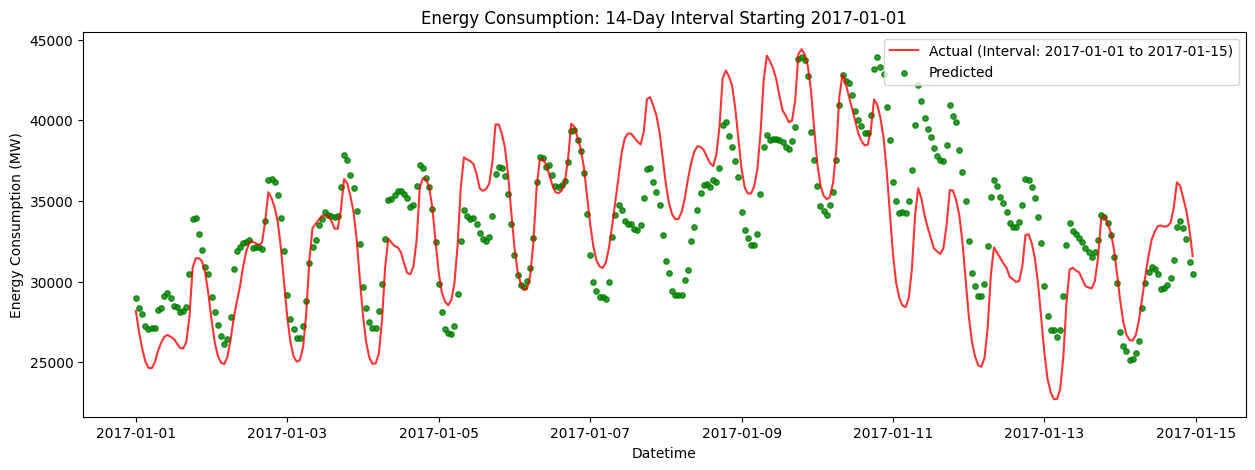

In [66]:
start_date = "2017-01-01"
plot_14_day_interval(y_test, y_pred, start_date)

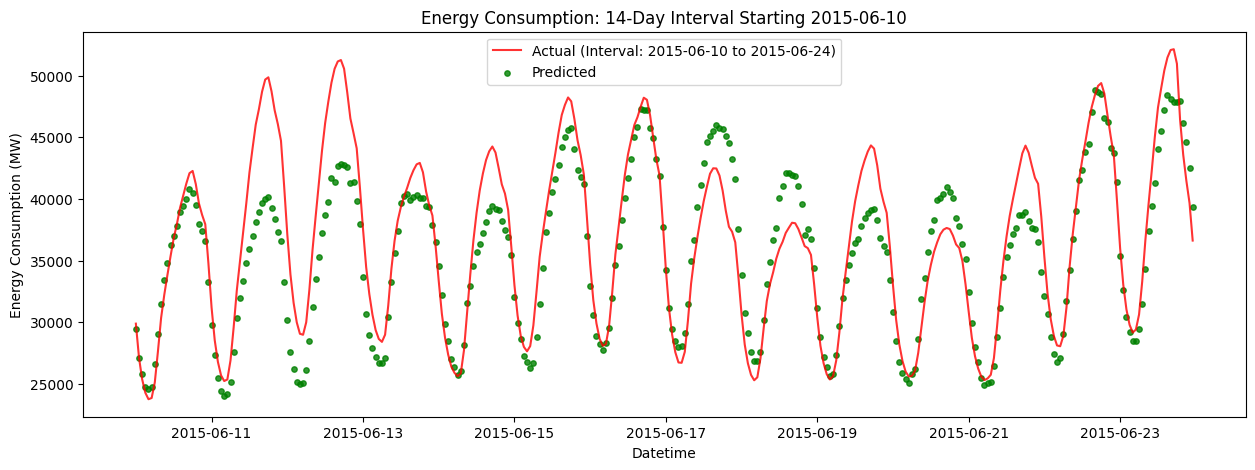

In [67]:
start_date = "2015-06-10"
plot_14_day_interval(y_test, y_pred, start_date)

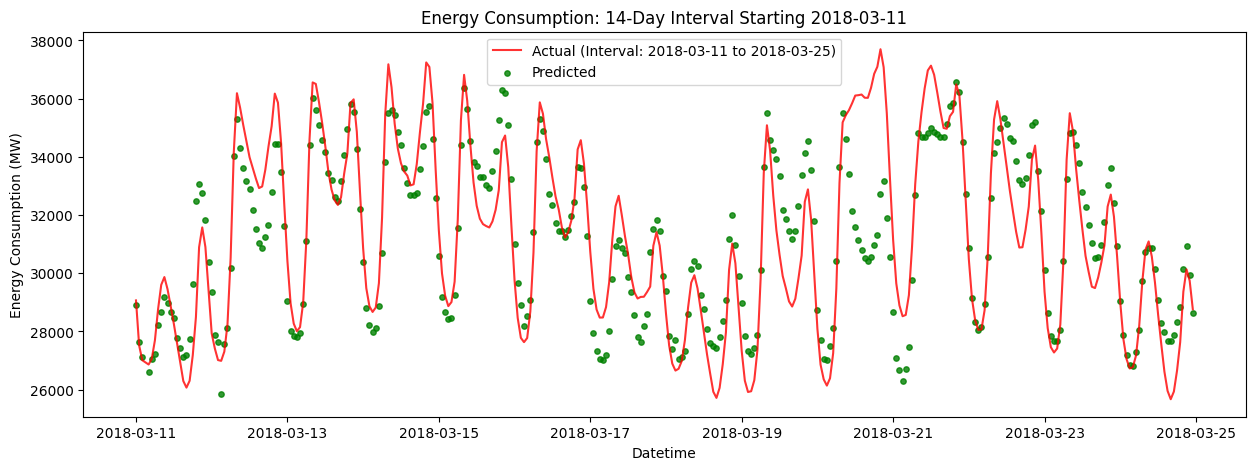

In [68]:
start_date = "2018-03-11"
plot_14_day_interval(y_test, y_pred, start_date)

## CASE 6: ADD LAG FEATURES - HOURLY FREQUENCY

### CREATE LAG FEATURES

In [69]:
file_path = "/content/hourly-energy-consumption/PJME_hourly.csv"
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


In [70]:
df = create_lagged_features(df, target_col="PJME_MW", freq="H")
df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
Datetime                                                                   
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-08-02 20:00:00  44057.0  2018        3      8    2    20          3   
2018-08-02 21:00:00  43256.0  2018        3      8    2    21          3   
2018-08-02 22:00:00  41552.0  2018        3      8    2    22          3   
2018-08-02 23:00:00  38500.0  2018        3      8    2    23          3   
2018-08-03 00:00:00  35486.0  2018        3      8    3     0          4   

                     IsWeekend  Season    Lag1H    Lag1D    Lag1W    Lag1M  \
Datetime                                                                     
2002-01-01 01:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 02:00:00          0       1  30393.0      NaN      NaN      NaN   
2002-01-01 03:00:00          0       1  29265.0      NaN      NaN      NaN   
2002-01-01 04:00:00          0       1  28357.0      NaN      NaN      NaN   
2002-01-01 05:00:00          0       1  27899.0      NaN      NaN      NaN   
...                        ...     ...      ...      ...      ...      ...   
2018-08-02 20:00:00          0       3  45641.0  46912.0  46337.0  49244.0   
2018-08-02 21:00:00          0       3  44057.0  45985.0  44542.0  47292.0   
2018-08-02 22:00:00          0       3  43256.0  44094.0  42638.0  45506.0   
2018-08-02 23:00:00          0       3  41552.0  40666.0  39276.0  42437.0   
2018-08-03 00:00:00          0       3  38500.0  37158.0  35742.0  39340.0   

                       Lag1Y    Lag3Y  
Datetime                               
2002-01-01 01:00:00      NaN      NaN  
2002-01-01 02:00:00      NaN      NaN  
2002-01-01 03:00:00      NaN      NaN  
2002-01-01 04:00:00      NaN      NaN  
2002-01-01 05:00:00      NaN      NaN  
...                      ...      ...  
2018-08-02 20:00:00  39352.0  46942.0  
2018-08-02 21:00:00  38699.0  45730.0  
2018-08-02 22:00:00  37346.0  43954.0  
2018-08-02 23:00:00  34555.0  40390.0  
2018-08-03 00:00:00  31646.0  36825.0  

[145362 rows x 15 columns]

### TRAIN-TEST SPLIT

In [71]:
train = df.loc[(df.index < "01-01-2015")]
test = df.loc[(df.index >= "01-01-2015")]

X_train = train.drop(columns=["PJME_MW"])
y_train = train["PJME_MW"]
X_test = test.drop(columns=["PJME_MW"])
y_test = test["PJME_MW"]

### MODEL

#### RUN MODEL

In [72]:
xgb_model = train_xgb_model(X_train, y_train, X_test, y_test)

[0]	validation_0-rmse:6206.32463
[100]	validation_0-rmse:553.89882
[200]	validation_0-rmse:467.39490
[300]	validation_0-rmse:440.97746
[400]	validation_0-rmse:419.80652
[500]	validation_0-rmse:408.79758
[600]	validation_0-rmse:402.68535
[700]	validation_0-rmse:397.82212
[800]	validation_0-rmse:396.26037
[900]	validation_0-rmse:394.50431
[1000]	validation_0-rmse:391.59060
[1100]	validation_0-rmse:388.89812
[1200]	validation_0-rmse:386.48818
[1300]	validation_0-rmse:385.62720
[1400]	validation_0-rmse:383.85800
[1500]	validation_0-rmse:382.45875
[1600]	validation_0-rmse:381.22506
[1700]	validation_0-rmse:380.40470
[1800]	validation_0-rmse:380.31596
[1806]	validation_0-rmse:380.24277


#### PREDICTION & EVALUATION

In [73]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 380.1240021736964


#### SAVE ERROR

In [74]:
rms_error.append(rmse)

### PLOT RESULTS ON 14 TIME INTERVAL

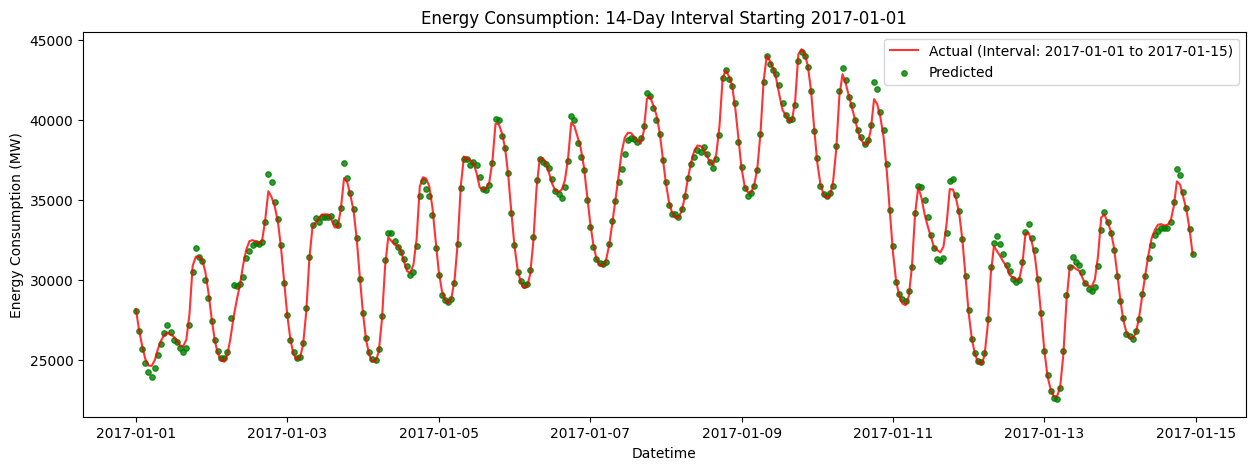

In [75]:
start_date = "2017-01-01"
plot_14_day_interval(y_test, y_pred, start_date)

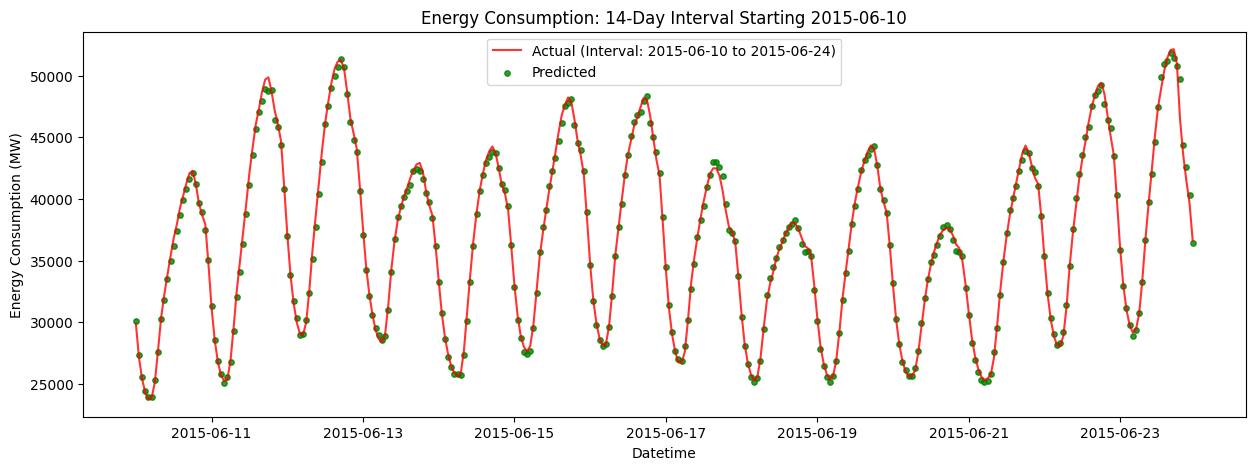

In [76]:
start_date = "2015-06-10"
plot_14_day_interval(y_test, y_pred, start_date)

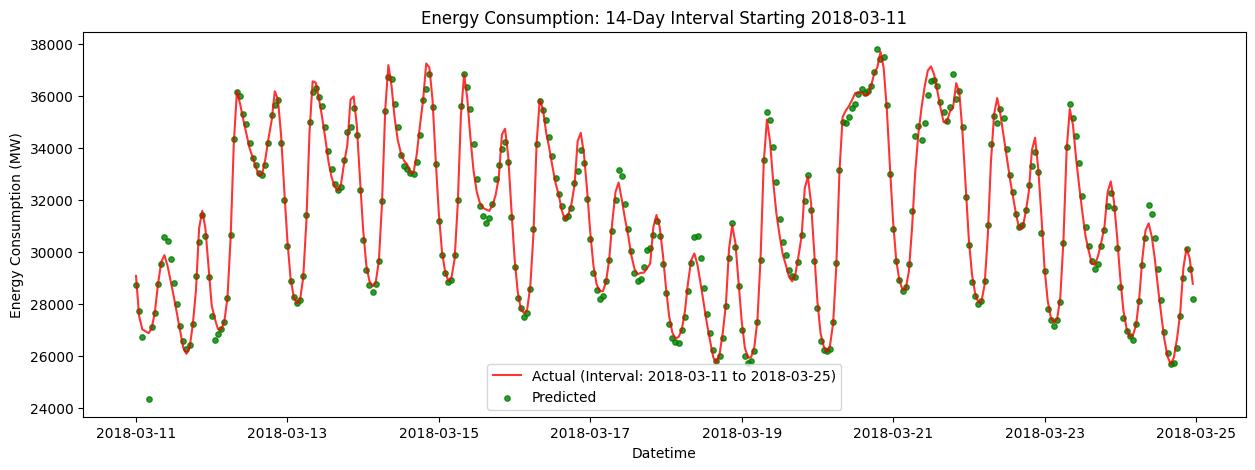

In [77]:
start_date = "2018-03-11"
plot_14_day_interval(y_test, y_pred, start_date)

## PLOT ERRORS

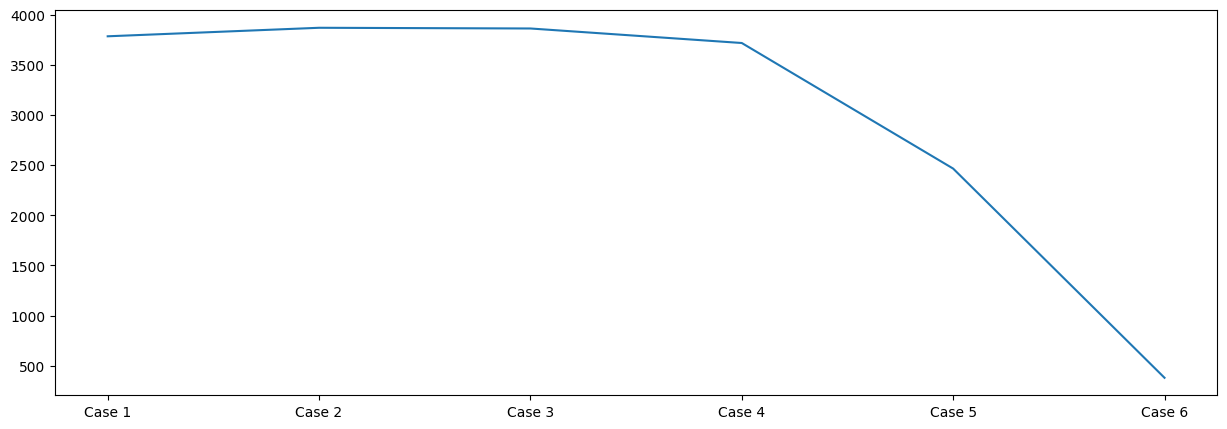

In [78]:
plt.figure(figsize=(15, 5))
x_label=[f"Case {i}" for i in range(1,7)]
plt.plot(x_label, rms_error)

# FORECASTING

## CASE 1 - 1 YEAR FORECAST

### DATASET DOWNLOAD

In [79]:
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")

### DROP DUPLICATES & CREATE ADDITIONAL FEATURES

In [80]:
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


###CREATE LAG FEATURES

In [81]:
df = create_lagged_features(df, target_col="PJME_MW", freq="A")

### TRAIN MODEL

In [82]:
X_all = df.drop(columns=["PJME_MW"])
y_all = df["PJME_MW"]
xgb_model = train_xgb_model(X_all, y_all, X_all, y_all)

[0]	validation_0-rmse:6256.23380
[100]	validation_0-rmse:3007.66260
[200]	validation_0-rmse:2676.16060
[300]	validation_0-rmse:2514.83611
[400]	validation_0-rmse:2393.28899
[500]	validation_0-rmse:2300.27306
[600]	validation_0-rmse:2217.34036
[700]	validation_0-rmse:2143.91673
[800]	validation_0-rmse:2081.40739
[900]	validation_0-rmse:2026.96972
[1000]	validation_0-rmse:1975.29733
[1100]	validation_0-rmse:1933.46119
[1200]	validation_0-rmse:1889.81414
[1300]	validation_0-rmse:1845.43226
[1400]	validation_0-rmse:1810.83469
[1500]	validation_0-rmse:1778.50270
[1600]	validation_0-rmse:1747.98371
[1700]	validation_0-rmse:1716.93561
[1800]	validation_0-rmse:1685.41346
[1900]	validation_0-rmse:1658.34745
[1999]	validation_0-rmse:1627.39417


### CREATE FORECASTING DATASET

In [83]:
start_date = df.last_valid_index() + pd.DateOffset(hours=1)
end_date = pd.to_datetime(start_date)+pd.DateOffset(days=364)
datelist = pd.date_range(start=str(start_date),end=str(end_date), freq="h")

In [84]:
forecast_df = pd.DataFrame(index=datelist)
forecast_df["PJME_MW"]=np.nan
forecast_df = create_time_series_features(forecast_df, target_col="PJME_MW")
forecast_df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
2018-08-03 01:00:00      NaN  2018        3      8    3     1          4   
2018-08-03 02:00:00      NaN  2018        3      8    3     2          4   
2018-08-03 03:00:00      NaN  2018        3      8    3     3          4   
2018-08-03 04:00:00      NaN  2018        3      8    3     4          4   
2018-08-03 05:00:00      NaN  2018        3      8    3     5          4   
...                      ...   ...      ...    ...  ...   ...        ...   
2019-08-01 21:00:00      NaN  2019        3      8    1    21          3   
2019-08-01 22:00:00      NaN  2019        3      8    1    22          3   
2019-08-01 23:00:00      NaN  2019        3      8    1    23          3   
2019-08-02 00:00:00      NaN  2019        3      8    2     0          4   
2019-08-02 01:00:00      NaN  2019        3      8    2     1          4   

                     IsWeekend  Season  
2018-08-03 01:00:00          0       3  
2018-08-03 02:00:00          0       3  
2018-08-03 03:00:00          0       3  
2018-08-03 04:00:00          0       3  
2018-08-03 05:00:00          0       3  
...                        ...     ...  
2019-08-01 21:00:00          0       3  
2019-08-01 22:00:00          0       3  
2019-08-01 23:00:00          0       3  
2019-08-02 00:00:00          0       3  
2019-08-02 01:00:00          0       3  

[8737 rows x 9 columns]

### CONCATENATE ORIGINAL DATASET & FORECASTING DATASET

In [85]:
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")
df_and_forecast = pd.concat([df, forecast_df])
df_and_forecast = create_lagged_features(df_and_forecast, target_col="PJME_MW", freq="A")

df_and_forecast

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2019-08-01 21:00:00      NaN  2019        3      8    1    21          3   
2019-08-01 22:00:00      NaN  2019        3      8    1    22          3   
2019-08-01 23:00:00      NaN  2019        3      8    1    23          3   
2019-08-02 00:00:00      NaN  2019        3      8    2     0          4   
2019-08-02 01:00:00      NaN  2019        3      8    2     1          4   

                     IsWeekend  Season    Lag1Y    Lag3Y  
2002-01-01 01:00:00          0       1      NaN      NaN  
2002-01-01 02:00:00          0       1      NaN      NaN  
2002-01-01 03:00:00          0       1      NaN      NaN  
2002-01-01 04:00:00          0       1      NaN      NaN  
2002-01-01 05:00:00          0       1      NaN      NaN  
...                        ...     ...      ...      ...  
2019-08-01 21:00:00          0       3  45985.0  40979.0  
2019-08-01 22:00:00          0       3  44094.0  39595.0  
2019-08-01 23:00:00          0       3  40666.0  36774.0  
2019-08-02 00:00:00          0       3  37158.0  33643.0  
2019-08-02 01:00:00          0       3  34283.0  30964.0  

[154099 rows x 11 columns]

### MAKE FORECAST

In [86]:
forecast = df_and_forecast.loc[(df_and_forecast.index > str(start_date))]
X_forecast = forecast.drop(columns=["PJME_MW"])
y_forecast = xgb_model.predict(X_forecast)
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"]=y_forecast

### PLOT FORECAST

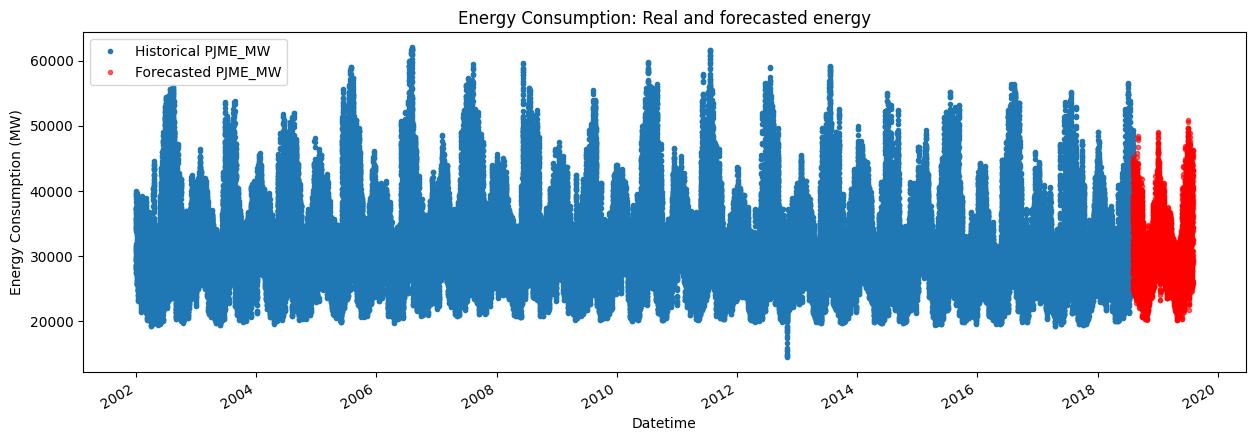

In [87]:
df_and_forecast.loc[(df_and_forecast.index <= str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = current_palette[0], label="Historical PJME_MW")
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.6, label="Forecasted PJME_MW")

plt.title("Energy Consumption: Real and forecasted energy")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")
plt.legend()

plt.show()

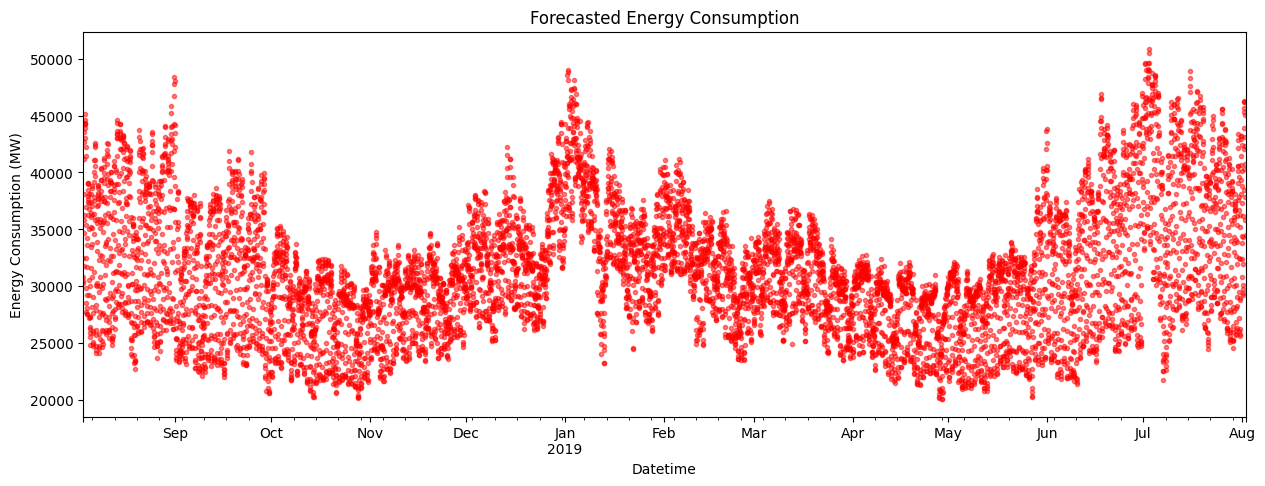

In [88]:
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.5)
plt.title("Forecasted Energy Consumption")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")

plt.show()

## CASE 2 - 1 MONTH FORECAST

### DATASET DOWNLOAD

In [89]:
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")

### DROP DUPLICATES & CREATE ADDITIONAL FEATURES

In [90]:
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


###CREATE LAG FEATURES

In [91]:
df = create_lagged_features(df, target_col="PJME_MW", freq="M")

### TRAIN MODEL

In [92]:
X_all = df.drop(columns=["PJME_MW"])
y_all = df["PJME_MW"]
xgb_model = train_xgb_model(X_all, y_all, X_all, y_all)

[0]	validation_0-rmse:6258.50482
[100]	validation_0-rmse:2997.07555
[200]	validation_0-rmse:2670.01913
[300]	validation_0-rmse:2498.83399
[400]	validation_0-rmse:2369.24201
[500]	validation_0-rmse:2268.98798
[600]	validation_0-rmse:2182.59490
[700]	validation_0-rmse:2103.74212
[800]	validation_0-rmse:2034.23618
[900]	validation_0-rmse:1977.34849
[1000]	validation_0-rmse:1926.07384
[1100]	validation_0-rmse:1872.95470
[1200]	validation_0-rmse:1823.32003
[1300]	validation_0-rmse:1781.43494
[1400]	validation_0-rmse:1739.11606
[1500]	validation_0-rmse:1698.52729
[1600]	validation_0-rmse:1666.62884
[1700]	validation_0-rmse:1638.25342
[1800]	validation_0-rmse:1605.05416
[1900]	validation_0-rmse:1577.04522
[1999]	validation_0-rmse:1548.98496


### CREATE FORECASTING DATASET

In [93]:
start_date = df.last_valid_index() + pd.DateOffset(hours=1)
end_date = pd.to_datetime(start_date)+pd.DateOffset(days=30)
datelist = pd.date_range(start=str(start_date),end=str(end_date), freq="h")

In [94]:
forecast_df = pd.DataFrame(index=datelist)
forecast_df["PJME_MW"]=np.nan
forecast_df = create_time_series_features(forecast_df, target_col="PJME_MW")
forecast_df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
2018-08-03 01:00:00      NaN  2018        3      8    3     1          4   
2018-08-03 02:00:00      NaN  2018        3      8    3     2          4   
2018-08-03 03:00:00      NaN  2018        3      8    3     3          4   
2018-08-03 04:00:00      NaN  2018        3      8    3     4          4   
2018-08-03 05:00:00      NaN  2018        3      8    3     5          4   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-09-01 21:00:00      NaN  2018        3      9    1    21          5   
2018-09-01 22:00:00      NaN  2018        3      9    1    22          5   
2018-09-01 23:00:00      NaN  2018        3      9    1    23          5   
2018-09-02 00:00:00      NaN  2018        3      9    2     0          6   
2018-09-02 01:00:00      NaN  2018        3      9    2     1          6   

                     IsWeekend  Season  
2018-08-03 01:00:00          0       3  
2018-08-03 02:00:00          0       3  
2018-08-03 03:00:00          0       3  
2018-08-03 04:00:00          0       3  
2018-08-03 05:00:00          0       3  
...                        ...     ...  
2018-09-01 21:00:00          1       4  
2018-09-01 22:00:00          1       4  
2018-09-01 23:00:00          1       4  
2018-09-02 00:00:00          1       4  
2018-09-02 01:00:00          1       4  

[721 rows x 9 columns]

### CONCATENATE ORIGINAL DATASET & FORECASTING DATASET

In [95]:
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")
df_and_forecast = pd.concat([df, forecast_df])
df_and_forecast = create_lagged_features(df_and_forecast, target_col="PJME_MW", freq="M")

df_and_forecast

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-09-01 21:00:00      NaN  2018        3      9    1    21          5   
2018-09-01 22:00:00      NaN  2018        3      9    1    22          5   
2018-09-01 23:00:00      NaN  2018        3      9    1    23          5   
2018-09-02 00:00:00      NaN  2018        3      9    2     0          6   
2018-09-02 01:00:00      NaN  2018        3      9    2     1          6   

                     IsWeekend  Season    Lag1M    Lag1Y    Lag3Y  
2002-01-01 01:00:00          0       1      NaN      NaN      NaN  
2002-01-01 02:00:00          0       1      NaN      NaN      NaN  
2002-01-01 03:00:00          0       1      NaN      NaN      NaN  
2002-01-01 04:00:00          0       1      NaN      NaN      NaN  
2002-01-01 05:00:00          0       1      NaN      NaN      NaN  
...                        ...     ...      ...      ...      ...  
2018-09-01 21:00:00          1       4  43256.0  28959.0  46197.0  
2018-09-01 22:00:00          1       4  41552.0  27779.0  43294.0  
2018-09-01 23:00:00          1       4  38500.0  26034.0  39238.0  
2018-09-02 00:00:00          1       4  35486.0  24104.0  35437.0  
2018-09-02 01:00:00          1       4      NaN  22550.0  32410.0  

[146083 rows x 12 columns]

### MAKE FORECAST

In [96]:
forecast = df_and_forecast.loc[(df_and_forecast.index > str(start_date))]
X_forecast = forecast.drop(columns=["PJME_MW"])
y_forecast = xgb_model.predict(X_forecast)
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"]=y_forecast

### PLOT FORECAST

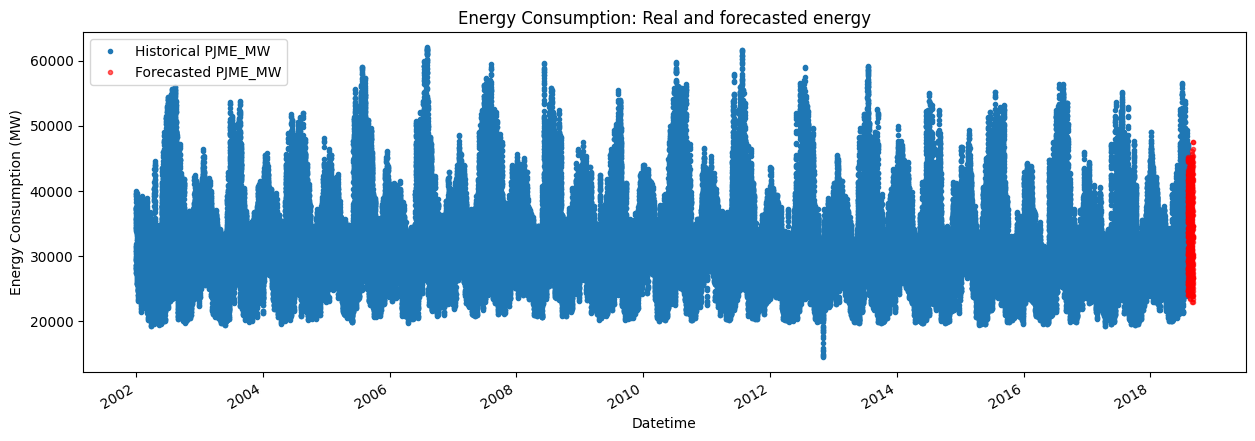

In [97]:
df_and_forecast.loc[(df_and_forecast.index <= str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = current_palette[0], label="Historical PJME_MW")
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.6, label="Forecasted PJME_MW")

plt.title("Energy Consumption: Real and forecasted energy")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")
plt.legend()

plt.show()

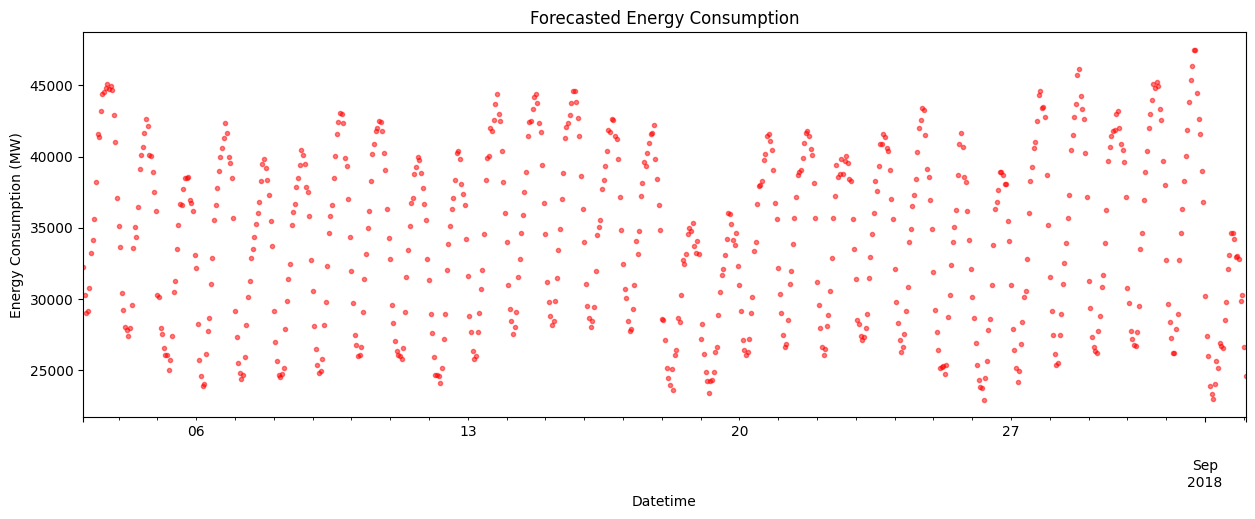

In [98]:
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.5)
plt.title("Forecasted Energy Consumption")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")

plt.show()

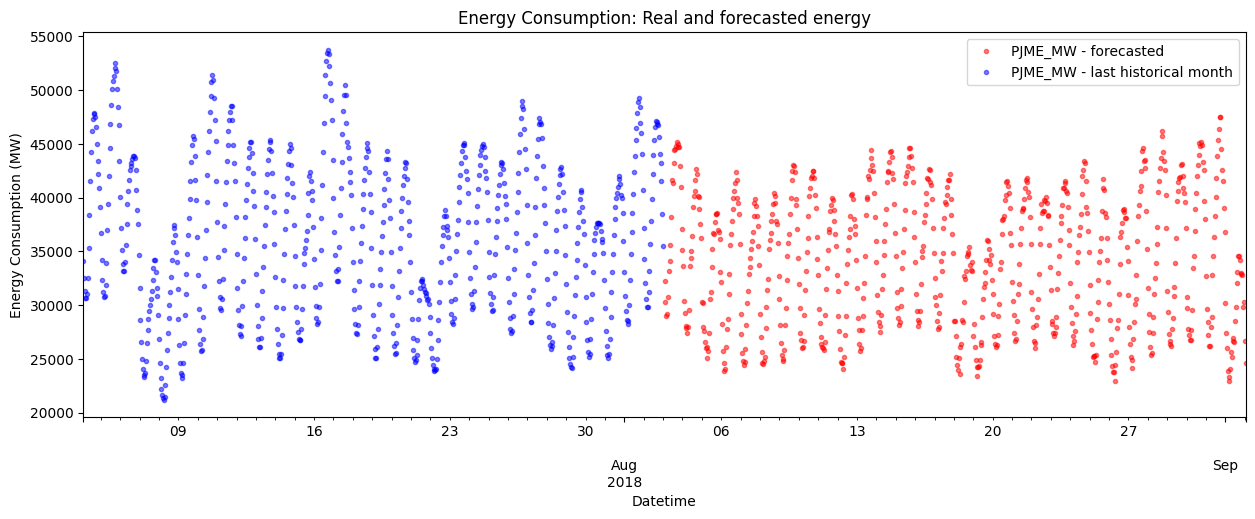

In [99]:
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.5, label="PJME_MW - forecasted")
df_and_forecast.loc[((df_and_forecast.index > (start_date - pd.DateOffset(hours=24*30))) & (df_and_forecast.index < str(start_date))), "PJME_MW"].plot(style = ".", figsize = (15, 5), color = "blue", alpha = 0.5, label = "PJME_MW - last historical month")
plt.title("Energy Consumption: Real and forecasted energy")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")
plt.legend()

plt.show()

## CASE 3 - 1 WEEK FORECAST

### DATASET DOWNLOAD

In [100]:
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")

### DROP DUPLICATES & CREATE ADDITIONAL FEATURES

In [101]:
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


###CREATE LAG FEATURES

In [102]:
df = create_lagged_features(df, target_col="PJME_MW", freq="W")

### TRAIN MODEL

In [103]:
X_all = df.drop(columns=["PJME_MW"])
y_all = df["PJME_MW"]
xgb_model = train_xgb_model(X_all, y_all, X_all, y_all)

[0]	validation_0-rmse:6245.32995
[100]	validation_0-rmse:2996.88384
[200]	validation_0-rmse:2690.61027
[300]	validation_0-rmse:2515.91817
[400]	validation_0-rmse:2393.95479
[500]	validation_0-rmse:2291.98367
[600]	validation_0-rmse:2204.98075
[700]	validation_0-rmse:2133.91112
[800]	validation_0-rmse:2067.19504
[900]	validation_0-rmse:2007.22705
[1000]	validation_0-rmse:1948.91552
[1100]	validation_0-rmse:1899.90341
[1200]	validation_0-rmse:1852.81450
[1300]	validation_0-rmse:1802.77882
[1400]	validation_0-rmse:1758.48390
[1500]	validation_0-rmse:1719.52772
[1600]	validation_0-rmse:1682.57828
[1700]	validation_0-rmse:1642.75425
[1800]	validation_0-rmse:1610.70731
[1900]	validation_0-rmse:1579.89193
[1999]	validation_0-rmse:1550.45071


### CREATE FORECASTING DATASET

In [104]:
start_date = df.last_valid_index() + pd.DateOffset(hours=1)
end_date = pd.to_datetime(start_date)+pd.DateOffset(days=7)
datelist = pd.date_range(start=str(start_date),end=str(end_date), freq="h")

In [105]:
forecast_df = pd.DataFrame(index=datelist)
forecast_df["PJME_MW"]=np.nan
forecast_df = create_time_series_features(forecast_df, target_col="PJME_MW")
forecast_df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
2018-08-03 01:00:00      NaN  2018        3      8    3     1          4   
2018-08-03 02:00:00      NaN  2018        3      8    3     2          4   
2018-08-03 03:00:00      NaN  2018        3      8    3     3          4   
2018-08-03 04:00:00      NaN  2018        3      8    3     4          4   
2018-08-03 05:00:00      NaN  2018        3      8    3     5          4   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-08-09 21:00:00      NaN  2018        3      8    9    21          3   
2018-08-09 22:00:00      NaN  2018        3      8    9    22          3   
2018-08-09 23:00:00      NaN  2018        3      8    9    23          3   
2018-08-10 00:00:00      NaN  2018        3      8   10     0          4   
2018-08-10 01:00:00      NaN  2018        3      8   10     1          4   

                     IsWeekend  Season  
2018-08-03 01:00:00          0       3  
2018-08-03 02:00:00          0       3  
2018-08-03 03:00:00          0       3  
2018-08-03 04:00:00          0       3  
2018-08-03 05:00:00          0       3  
...                        ...     ...  
2018-08-09 21:00:00          0       3  
2018-08-09 22:00:00          0       3  
2018-08-09 23:00:00          0       3  
2018-08-10 00:00:00          0       3  
2018-08-10 01:00:00          0       3  

[169 rows x 9 columns]

### CONCATENATE ORIGINAL DATASET & FORECASTING DATASET

In [106]:
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")
df_and_forecast = pd.concat([df, forecast_df])
df_and_forecast = create_lagged_features(df_and_forecast, target_col="PJME_MW", freq="W")

df_and_forecast

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-08-09 21:00:00      NaN  2018        3      8    9    21          3   
2018-08-09 22:00:00      NaN  2018        3      8    9    22          3   
2018-08-09 23:00:00      NaN  2018        3      8    9    23          3   
2018-08-10 00:00:00      NaN  2018        3      8   10     0          4   
2018-08-10 01:00:00      NaN  2018        3      8   10     1          4   

                     IsWeekend  Season    Lag1W    Lag1M    Lag1Y    Lag3Y  
2002-01-01 01:00:00          0       1      NaN      NaN      NaN      NaN  
2002-01-01 02:00:00          0       1      NaN      NaN      NaN      NaN  
2002-01-01 03:00:00          0       1      NaN      NaN      NaN      NaN  
2002-01-01 04:00:00          0       1      NaN      NaN      NaN      NaN  
2002-01-01 05:00:00          0       1      NaN      NaN      NaN      NaN  
...                        ...     ...      ...      ...      ...      ...  
2018-08-09 21:00:00          0       3  43256.0  47194.0  38245.0  36983.0  
2018-08-09 22:00:00          0       3  41552.0  45245.0  36424.0  35859.0  
2018-08-09 23:00:00          0       3  38500.0  41533.0  33222.0  33334.0  
2018-08-10 00:00:00          0       3  35486.0  37750.0  30096.0  30822.0  
2018-08-10 01:00:00          0       3      NaN  34491.0  27541.0  28663.0  

[145531 rows x 13 columns]

### MAKE FORECAST

In [107]:
forecast = df_and_forecast.loc[(df_and_forecast.index > str(start_date))]
X_forecast = forecast.drop(columns=["PJME_MW"])
y_forecast = xgb_model.predict(X_forecast)
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"]=y_forecast

### PLOT FORECAST

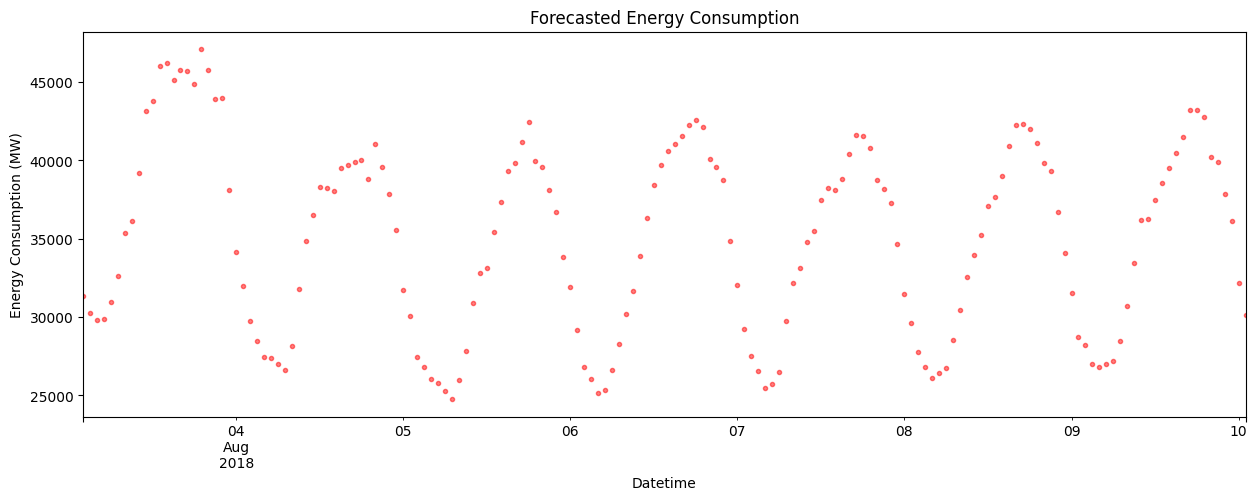

In [108]:
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.5)
plt.title("Forecasted Energy Consumption")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")

plt.show()

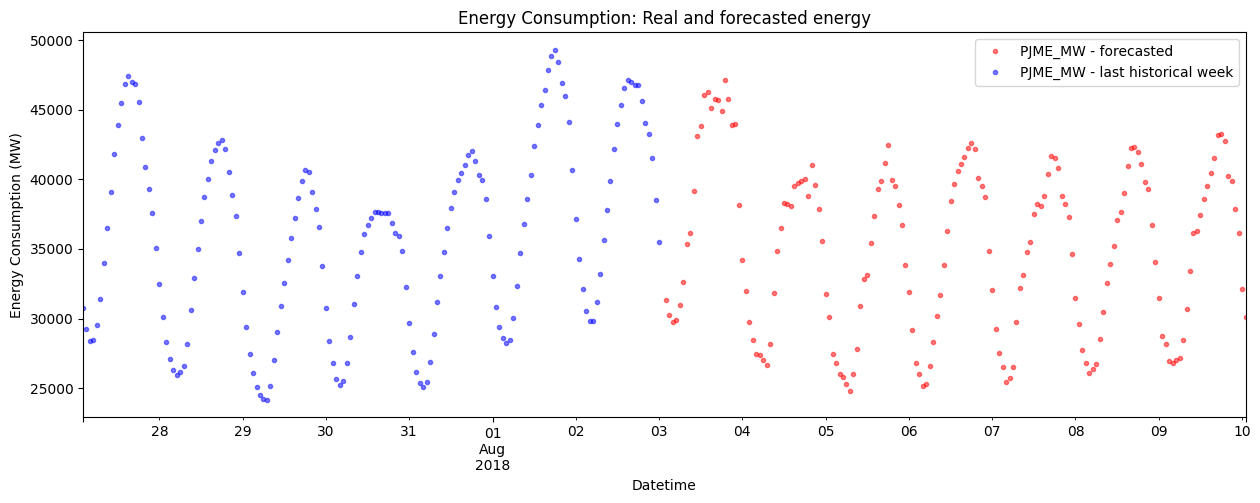

In [109]:
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.5, label="PJME_MW - forecasted")
df_and_forecast.loc[((df_and_forecast.index > (start_date - pd.DateOffset(hours=24*7))) & (df_and_forecast.index < str(start_date))), "PJME_MW"].plot(style = ".", figsize = (15, 5), color = "blue", alpha = 0.5, label = "PJME_MW - last historical week")
plt.title("Energy Consumption: Real and forecasted energy")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")
plt.legend()

plt.show()

## CASE 4 - 1 DAILY FORECAST

### DATASET DOWNLOAD

In [110]:
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")

### DROP DUPLICATES & CREATE ADDITIONAL FEATURES

In [111]:
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


###CREATE LAG FEATURES

In [112]:
df = create_lagged_features(df, target_col="PJME_MW", freq="D")

### TRAIN MODEL

In [113]:
X_all = df.drop(columns=["PJME_MW"])
y_all = df["PJME_MW"]
xgb_model = train_xgb_model(X_all, y_all, X_all, y_all)

[0]	validation_0-rmse:6188.58577
[100]	validation_0-rmse:2092.14155
[200]	validation_0-rmse:1961.72616
[300]	validation_0-rmse:1868.45065
[400]	validation_0-rmse:1793.39528
[500]	validation_0-rmse:1734.65998
[600]	validation_0-rmse:1689.92281
[700]	validation_0-rmse:1648.74431
[800]	validation_0-rmse:1610.43188
[900]	validation_0-rmse:1576.52123
[1000]	validation_0-rmse:1543.71074
[1100]	validation_0-rmse:1510.90466
[1200]	validation_0-rmse:1482.04814
[1300]	validation_0-rmse:1457.72845
[1400]	validation_0-rmse:1433.34143
[1500]	validation_0-rmse:1409.50251
[1600]	validation_0-rmse:1386.35431
[1700]	validation_0-rmse:1365.24871
[1800]	validation_0-rmse:1344.48083
[1900]	validation_0-rmse:1322.69185
[1999]	validation_0-rmse:1302.98707


### CREATE FORECASTING DATASET

In [114]:
start_date = df.last_valid_index() + pd.DateOffset(hours=1)
end_date = pd.to_datetime(start_date)+pd.DateOffset(days=1)
datelist = pd.date_range(start=str(start_date),end=str(end_date), freq="h")

In [115]:
forecast_df = pd.DataFrame(index=datelist)
forecast_df["PJME_MW"]=np.nan
forecast_df = create_time_series_features(forecast_df, target_col="PJME_MW")
forecast_df

PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
2018-08-03 01:00:00      NaN  2018        3      8    3     1          4   
2018-08-03 02:00:00      NaN  2018        3      8    3     2          4   
2018-08-03 03:00:00      NaN  2018        3      8    3     3          4   
2018-08-03 04:00:00      NaN  2018        3      8    3     4          4   
2018-08-03 05:00:00      NaN  2018        3      8    3     5          4   
2018-08-03 06:00:00      NaN  2018        3      8    3     6          4   
2018-08-03 07:00:00      NaN  2018        3      8    3     7          4   
2018-08-03 08:00:00      NaN  2018        3      8    3     8          4   
2018-08-03 09:00:00      NaN  2018        3      8    3     9          4   
2018-08-03 10:00:00      NaN  2018        3      8    3    10          4   
2018-08-03 11:00:00      NaN  2018        3      8    3    11          4   
2018-08-03 12:00:00      NaN  2018        3      8    3    12          4   
2018-08-03 13:00:00      NaN  2018        3      8    3    13          4   
2018-08-03 14:00:00      NaN  2018        3      8    3    14          4   
2018-08-03 15:00:00      NaN  2018        3      8    3    15          4   
2018-08-03 16:00:00      NaN  2018        3      8    3    16          4   
2018-08-03 17:00:00      NaN  2018        3      8    3    17          4   
2018-08-03 18:00:00      NaN  2018        3      8    3    18          4   
2018-08-03 19:00:00      NaN  2018        3      8    3    19          4   
2018-08-03 20:00:00      NaN  2018        3      8    3    20          4   
2018-08-03 21:00:00      NaN  2018        3      8    3    21          4   
2018-08-03 22:00:00      NaN  2018        3      8    3    22          4   
2018-08-03 23:00:00      NaN  2018        3      8    3    23          4   
2018-08-04 00:00:00      NaN  2018        3      8    4     0          5   
2018-08-04 01:00:00      NaN  2018        3      8    4     1          5   

                     IsWeekend  Season  
2018-08-03 01:00:00          0       3  
2018-08-03 02:00:00          0       3  
2018-08-03 03:00:00          0       3  
2018-08-03 04:00:00          0       3  
2018-08-03 05:00:00          0       3  
2018-08-03 06:00:00          0       3  
2018-08-03 07:00:00          0       3  
2018-08-03 08:00:00          0       3  
2018-08-03 09:00:00          0       3  
2018-08-03 10:00:00          0       3  
2018-08-03 11:00:00          0       3  
2018-08-03 12:00:00          0       3  
2018-08-03 13:00:00          0       3  
2018-08-03 14:00:00          0       3  
2018-08-03 15:00:00          0       3  
2018-08-03 16:00:00          0       3  
2018-08-03 17:00:00          0       3  
2018-08-03 18:00:00          0       3  
2018-08-03 19:00:00          0       3  
2018-08-03 20:00:00          0       3  
2018-08-03 21:00:00          0       3  
2018-08-03 22:00:00          0       3  
2018-08-03 23:00:00          0       3  
2018-08-04 00:00:00          1       3  
2018-08-04 01:00:00          1       3

### CONCATENATE ORIGINAL DATASET & FORECASTING DATASET

In [116]:
df = prepare_time_series_df(file_path, datetime_col="Datetime", target_col="PJME_MW")
df = check_and_drop_duplicates(df)
df = create_time_series_features(df, target_col="PJME_MW")
df_and_forecast = pd.concat([df, forecast_df])
df_and_forecast = create_lagged_features(df_and_forecast, target_col="PJME_MW", freq="D")

df_and_forecast

Found 8 duplicate index entries.
Duplicate indices: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)
Duplicates dropped.


PJME_MW  Year  Quarter  Month  Day  Hour  DayOfWeek  \
2002-01-01 01:00:00  30393.0  2002        1      1    1     1          1   
2002-01-01 02:00:00  29265.0  2002        1      1    1     2          1   
2002-01-01 03:00:00  28357.0  2002        1      1    1     3          1   
2002-01-01 04:00:00  27899.0  2002        1      1    1     4          1   
2002-01-01 05:00:00  28057.0  2002        1      1    1     5          1   
...                      ...   ...      ...    ...  ...   ...        ...   
2018-08-03 21:00:00      NaN  2018        3      8    3    21          4   
2018-08-03 22:00:00      NaN  2018        3      8    3    22          4   
2018-08-03 23:00:00      NaN  2018        3      8    3    23          4   
2018-08-04 00:00:00      NaN  2018        3      8    4     0          5   
2018-08-04 01:00:00      NaN  2018        3      8    4     1          5   

                     IsWeekend  Season    Lag1D    Lag1W    Lag1M    Lag1Y  \
2002-01-01 01:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 02:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 03:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 04:00:00          0       1      NaN      NaN      NaN      NaN   
2002-01-01 05:00:00          0       1      NaN      NaN      NaN      NaN   
...                        ...     ...      ...      ...      ...      ...   
2018-08-03 21:00:00          0       3  43256.0  39275.0  42157.0  41210.0   
2018-08-03 22:00:00          0       3  41552.0  37618.0  40860.0  39525.0   
2018-08-03 23:00:00          0       3  38500.0  35038.0  39131.0  36490.0   
2018-08-04 00:00:00          1       3  35486.0  32468.0  36699.0  33539.0   
2018-08-04 01:00:00          1       3      NaN  30085.0  34220.0  30781.0   

                       Lag3Y  
2002-01-01 01:00:00      NaN  
2002-01-01 02:00:00      NaN  
2002-01-01 03:00:00      NaN  
2002-01-01 04:00:00      NaN  
2002-01-01 05:00:00      NaN  
...                      ...  
2018-08-03 21:00:00  44510.0  
2018-08-03 22:00:00  42467.0  
2018-08-03 23:00:00  38646.0  
2018-08-04 00:00:00  34829.0  
2018-08-04 01:00:00  31693.0  

[145387 rows x 14 columns]

### MAKE FORECAST

In [117]:
forecast = df_and_forecast.loc[(df_and_forecast.index > str(start_date))]
X_forecast = forecast.drop(columns=["PJME_MW"])
y_forecast = xgb_model.predict(X_forecast)
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"]=y_forecast

### PLOT FORECAST

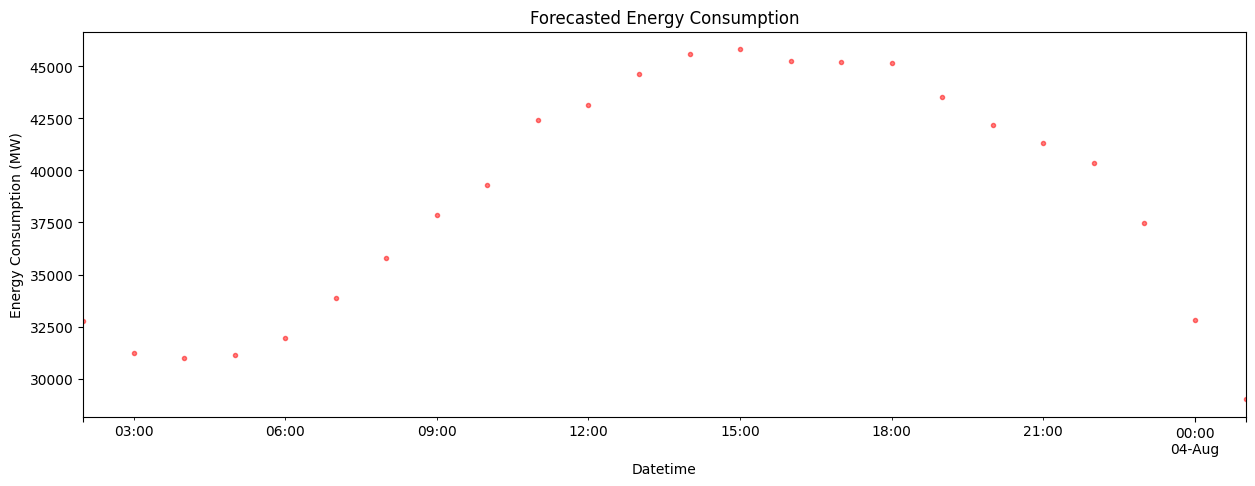

In [118]:
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.5)
plt.title("Forecasted Energy Consumption")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")

plt.show()

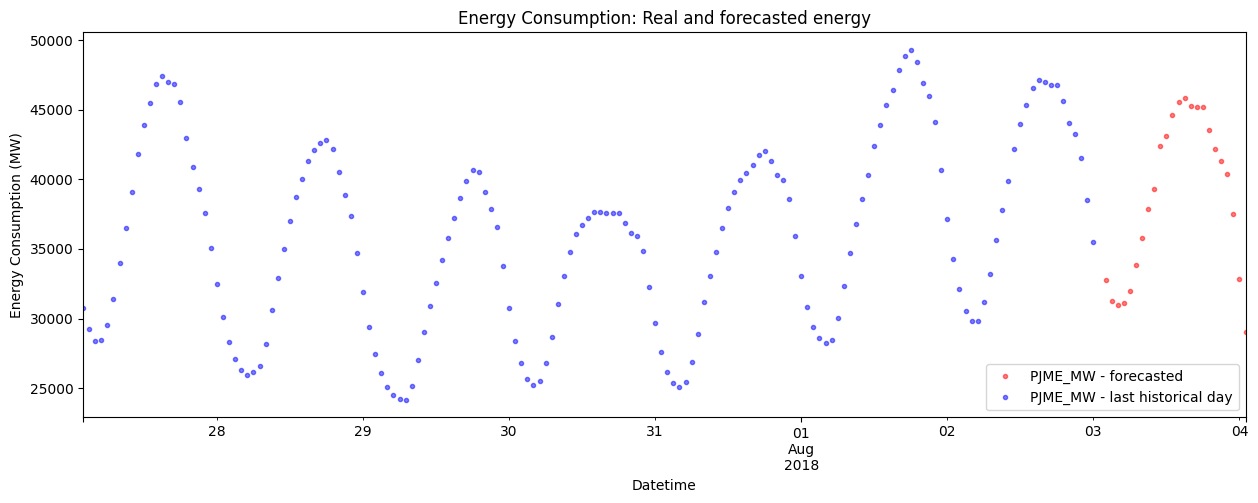

In [119]:
df_and_forecast.loc[(df_and_forecast.index > str(start_date)), "PJME_MW"].plot(style = ".", figsize = (15,5), color = "red", alpha=0.5, label="PJME_MW - forecasted")
df_and_forecast.loc[((df_and_forecast.index > (start_date - pd.DateOffset(hours=24*7))) & (df_and_forecast.index < str(start_date))), "PJME_MW"].plot(style = ".", figsize = (15, 5), color = "blue", alpha = 0.5, label = "PJME_MW - last historical day")
plt.title("Energy Consumption: Real and forecasted energy")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")
plt.legend()

plt.show()